### Coursework 2

In this coursework you will be aiming to complete two classification tasks. 
Both the classification tasks relate to text classification tasks. 

One task is to be solved using Support Vector Machines. The other has to be solved using Boosting.

The specific tasks and the marking for the various tasks are provided in the notebook. Each task is expected to be accompanied by a lab-report. Each task can have a concise lab report that is maximum of one page in an A4 size. You will be expected to submit your Jupyter Notebook and all lab reports as a single zip file. You could have additional functions implemented that you require for carrying out each task.


#### Task 1

In this task, you need to obtain sentiment analysis for the provided dataset. The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. You need to train an SVM based classifier to obtain train and check on the sample test dataset provided. The method will be evaluated also against an external test set. Please do not hardcode any dimensions or number of samples while writing the code. It should be possible to automate the testing and hardcoding values does not allow for automated testing. 

You are allowed to use scikit-learn to implement the SVM. However, you are expected to write your own kernels.

You are allowed to use the existing library functions such as scikit-learn or numpy for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom text kernels. Refer to the documentation provided [here](https://scikit-learn.org/stable/modules/svm.html) at 1.4.6.2 and an example [here](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html) for writing your own kernels.

Details regarding the marking have been provided in the coursework specification file. Ensure that the code can be run with different test files. 

#### Process the text and obtain a bag of words-based features 

### 1. Training and testing BoWs extraction

In [486]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from nltk.util import ngrams
from nltk import FreqDist
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import unidecode
import spacy
import en_core_web_sm
import contractions
import string
from tqdm.notebook import tqdm # for showing progress bar
from sklearn.model_selection import GridSearchCV
from textblob import TextBlob
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score  

nltk.download('stopwords')

# Initialization
pattern = re.compile(r"(.)\1{2,}")
punc_translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
num_translator = str.maketrans(string.digits, ' '*len(string.digits))
nlp = en_core_web_sm.load()
stopwords = stopwords.words('english')


custom_negation = ['rather', 'instead']
    
def pre_processing(dataset):
    
    to_return = []
    
    for i in tqdm(range(len(dataset))):
        filtered_data = []
        
        # (1) remove html tags
        dataset[i] = BeautifulSoup(dataset[i]).get_text()
        
        # (2) remove urls
        dataset[i] = re.sub(r'http\S+', '', dataset[i])
        dataset[i] = re.sub(r'www\S+', '', dataset[i])
        
        # (3) remove email addresses
        dataset[i] = re.sub(r'\S*@\S*\s?', '', dataset[i])
        
        # (3) convert to lower case
        dataset[i] = dataset[i].casefold()
        
        # (4) convert accented character
        dataset[i] = unidecode.unidecode(dataset[i]) 
        
        # (5) if there are >2 consecutive duplicated characters, convert to 2 consecutive duplicated characters
        # e.g. finallllly --> finally
        dataset[i] = pattern.sub(r"\1\1", dataset[i]) 
        
        # (6) expand contractions
        dataset[i] = contractions.fix(dataset[i])
        
        # (7) replace punctuation with space
        dataset[i] = dataset[i].translate(punc_translator)
        
        # (8) replace numbers with space
        dataset[i] = dataset[i].translate(num_translator)
        
        # (9) spacy tokenization
        tokens = nlp(dataset[i])
            
        for token in tokens:
            
            # Lemmatisation
            word = token.lemma_
            
            # filter out words that are:
            # - stopwords
            # - with length <= 2
            # - demonstratives (e.g. this, that, those)
            # - pronoun and proper nouns (e.g. names)
            # - spaces
            
            names = [ent.text for ent in tokens if ent.ent_type_]
            
            if (word != "-PRON-") and (word !="-PROPN-") and (word not in names) and (not token.is_space):
               
                #print(word)

                if (token.dep_ == 'neg') or (word in custom_negation):
                    filtered_data.append('_NEG_')
                    continue
                
                # remove the word "like" when it is used as preposition
                if (word == 'like' and token.dep_ == 'prep'):
                    continue
                
                # remove stopwords
                if (word in stopwords):
                    continue

                # remove words with len <= 2
                elif (len(word) <= 2):
                    continue

                else:
                    filtered_data.append(word)
        
        # join words
        filtered_data = ' '.join(filtered_data)
        
        # Negation tagging
        filtered_data = re.sub(r'_NEG_\s', '_NEG_', filtered_data)
        filtered_data = re.sub(r"(_NEG_)\1{1,}", '_NEG_', filtered_data) # remove duplicated negation tagging
        
        to_return.append(filtered_data)
        
    return to_return

def extract_bag_of_words_train_test(train_file, test_file):
    
    # Read the CSV files for training and test sets
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    
    X_train = np.array(train.review)
    X_test = np.array(test.review)
    y_train = np.array(train.sentiment)
    y_test = np.array(test.sentiment)
    
    # Extract bag of words features
    print("Train set: ")
    print("Preprocessing progress: ")
    X_train = pre_processing(X_train) 
    print("--Done--\n")
    print("Test set: ")
    print("Preprocessing progress: ")
    X_test = pre_processing(X_test)
    print('--Done--')
    
    return (X_train,y_train,X_test,y_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Sayuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [487]:
# self testing code - remove before submission
(X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")

Train set: 
Preprocessing progress: 


  0%|          | 0/5000 [00:00<?, ?it/s]

--Done--

Test set: 
Preprocessing progress: 


  0%|          | 0/1500 [00:00<?, ?it/s]

--Done--


### 2. Exploratory analysis
Visualising the distribution of positive and negative reviews in the training and testing sets respectively.

/Users/Sayuri/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


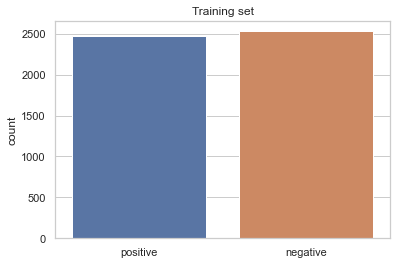

In [613]:

sns.set_theme(style="whitegrid")
sns.countplot(Y_train).set(title='Training set')

pd.options.display.float_format = "{:,.2f}".format

/Users/Sayuri/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Training set')]

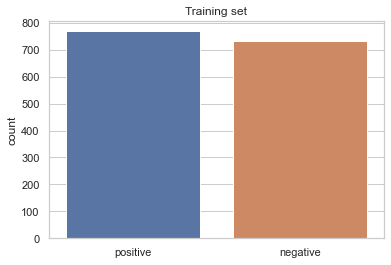

In [614]:
sns.countplot(Y_test).set(title='Testing set')

### 3: SVM classifier

In [629]:
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from nltk.tokenize import word_tokenize
import networkx as nx
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel import RandomWalk
from grakel.kernels import ShortestPath
from collections import defaultdict

class SVMClassifier:
    def __init__(self, kernel, C=None, gamma=None, coef=None, d=None, max_features=30000):
        
        #implement initialisation
        self.clf = svm.SVC()
        self.kernel = kernel
        self.vectorizer = None
        
        # regularization parameter
        self.C = C # penalty parameter
        
        # kernel parameters
        self.gamma = gamma # kernel coef for rbf, poly, sigmoid
        self.coef = coef #independent term for polynomial and sigmoid kernels
        self.d = d # degree; for polynomial kernel

        self.vectorizer = TfidfVectorizer(min_df = 2, # remove words that appear too rarely
                                          max_df = 0.7, # remove words that appear too often
                                          ngram_range=(1,5), # 1-2 gram
                                          max_features = max_features,
                                          smooth_idf = True, # +1 to all frequencies, prevent division by zero
                                          sublinear_tf = True #use log for TF, clip extreme values
                                          )
        
    # define your own kernel here
    # Refer to the documentation here: https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html
    
    # Implementation of kernels: https://github.com/gmum/pykernels/tree/master/pykernels
    
    def custom_kernel(self, X, y):
        
        X = X.A
        y = y.A
        
        print('Computing custom kernel...')
        
        # Histogram intersection kernel
        # ---------------- BEGIN ----------------#
        kernel = np.zeros((X.shape[0], y.shape[0]))

        for d in tqdm(range(X.shape[1])):
            column_1 = X[:, d].reshape(-1, 1)
            column_2 = y[:, d].reshape(-1, 1)
            kernel += np.minimum(column_1, column_2.T)

        # ------------------ END -----------------#
        
        return kernel
    
    def fit(self, X, y):
        # training of the SVM
        # Ensure you call your own defined kernel here

        # Transform data into tfidf feature vectors
        X = self.vectorizer.fit_transform(X)

        # calling diff kernels
        if self.kernel == 'linear':
            self.clf = svm.SVC(kernel='linear', C=self.C)

        elif self.kernel == 'poly':
            self.clf = svm.SVC(kernel='poly', C=self.C, degree=self.d)

        elif self.kernel == 'rbf':
            # for hyperparameter tuning
            self.clf = svm.SVC(kernel='rbf', C=self.C, gamma=self.gamma)

        elif self.kernel == 'custom':
            self.clf = svm.SVC(kernel=self.custom_kernel, C=self.C)
        
        self.clf.fit(X,y)
    
    def predict(self, X):
        
        # prediction routine for the SVM
        X = self.vectorizer.transform(X)
        
        return self.clf.predict(X)

### 3.1 SVM with custom kernel 

3.1.1 Hyperparameter tuning (C)

In [552]:
# self testing code - remove before submission
# Custom kernel - Splines

from sklearn.metrics import classification_report

# Hyperparameter grid search with cross-validation
custom_sc = SVMClassifier(kernel='custom', max_features=5000)
custom_kernel = custom_sc.custom_kernel

C_rng = np.logspace(-5,8,10,base=math.e)
params_grid = {'kernel': [custom_kernel],
               'C': C_rng}

custom_svc = svm.SVC()
custom_search = GridSearchCV(custom_svc, params_grid, cv=5, verbose=10, scoring='accuracy')
custom_X_train = custom_sc.vectorizer.fit_transform(X_train)
custom_search.fit(custom_X_train, Y_train)
print(custom_search.best_params_)
print(custom_search.best_estimator_)
print(custom_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 1/10] END C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.830 total time=16.9min
[CV 2/5; 1/10] START C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 1/10] END C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.825 total time=16.6min
[CV 3/5; 1/10] START C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 1/10] END C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.797 total time=16.1min
[CV 4/5; 1/10] START C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 1/10] END C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.826 total time=15.8min
[CV 5/5; 1/10] START C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 1/10] END C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.830 total time=16.4min
[CV 1/5; 2/10] START C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 2/10] END C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.857 total time=17.8min
[CV 2/5; 2/10] START C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 2/10] END C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.871 total time=17.9min
[CV 3/5; 2/10] START C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 2/10] END C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.836 total time=18.0min
[CV 4/5; 2/10] START C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 2/10] END C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.854 total time=16.8min
[CV 5/5; 2/10] START C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 2/10] END C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.872 total time=17.5min
[CV 1/5; 3/10] START C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 3/10] END C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.866 total time=16.6min
[CV 2/5; 3/10] START C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 3/10] END C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.867 total time=16.9min
[CV 3/5; 3/10] START C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 3/10] END C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.852 total time=17.3min
[CV 4/5; 3/10] START C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 3/10] END C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.864 total time=16.8min
[CV 5/5; 3/10] START C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 3/10] END C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.883 total time=16.6min
[CV 1/5; 4/10] START C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 4/10] END C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.855 total time=16.9min
[CV 2/5; 4/10] START C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 4/10] END C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.867 total time=17.4min
[CV 3/5; 4/10] START C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 4/10] END C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.848 total time=17.5min
[CV 4/5; 4/10] START C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 4/10] END C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.849 total time=17.8min
[CV 5/5; 4/10] START C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 4/10] END C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.870 total time=17.3min
[CV 1/5; 5/10] START C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 5/10] END C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.852 total time=16.7min
[CV 2/5; 5/10] START C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 5/10] END C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.859 total time=17.7min
[CV 3/5; 5/10] START C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 5/10] END C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.848 total time=16.9min
[CV 4/5; 5/10] START C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 5/10] END C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.845 total time=16.4min
[CV 5/5; 5/10] START C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 5/10] END C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.871 total time=17.0min
[CV 1/5; 6/10] START C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 6/10] END C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.852 total time=16.3min
[CV 2/5; 6/10] START C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 6/10] END C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.859 total time=16.0min
[CV 3/5; 6/10] START C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 6/10] END C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.848 total time=16.6min
[CV 4/5; 6/10] START C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 6/10] END C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.845 total time=16.8min
[CV 5/5; 6/10] START C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 6/10] END C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.871 total time=15.8min
[CV 1/5; 7/10] START C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 7/10] END C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.852 total time=15.6min
[CV 2/5; 7/10] START C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 7/10] END C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.859 total time=15.6min
[CV 3/5; 7/10] START C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 7/10] END C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.848 total time=15.6min
[CV 4/5; 7/10] START C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 7/10] END C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.845 total time=15.6min
[CV 5/5; 7/10] START C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 7/10] END C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.871 total time=15.6min
[CV 1/5; 8/10] START C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 8/10] END C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.852 total time=15.6min
[CV 2/5; 8/10] START C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 8/10] END C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.859 total time=15.6min
[CV 3/5; 8/10] START C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 8/10] END C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.848 total time=15.7min
[CV 4/5; 8/10] START C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 8/10] END C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.845 total time=15.6min
[CV 5/5; 8/10] START C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 8/10] END C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.871 total time=15.7min
[CV 1/5; 9/10] START C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 9/10] END C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.852 total time=15.9min
[CV 2/5; 9/10] START C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 9/10] END C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.859 total time=15.9min
[CV 3/5; 9/10] START C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 9/10] END C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.848 total time=15.9min
[CV 4/5; 9/10] START C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 9/10] END C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.845 total time=21.6min
[CV 5/5; 9/10] START C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 9/10] END C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.871 total time=16.8min
[CV 1/5; 10/10] START C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 10/10] END C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.852 total time=17.0min
[CV 2/5; 10/10] START C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 10/10] END C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.859 total time=17.0min
[CV 3/5; 10/10] START C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 10/10] END C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.848 total time=16.3min
[CV 4/5; 10/10] START C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 10/10] END C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.845 total time=15.6min
[CV 5/5; 10/10] START C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 10/10] END C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>;, score=0.871 total time=15.7min
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

{'C': 0.12110333239232973, 'kernel': <bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d83367790>>}
SVC(C=0.12110333239232973,
    kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7d8932e350>>)
0.8664


In [ ]:
# Helper function for plotting the hyperparameter tuning cv results

def plot_cv_results(df, xlabel, params_list):
    min_scores = [min(df.split0_test_score[i], 
                      df.split1_test_score[i], 
                      df.split2_test_score[i],
                      df.split3_test_score[i],
                      df.split4_test_score[i]) for i in range(len(df))]

    max_scores = [max(df.split0_test_score[i], 
                      df.split1_test_score[i], 
                      df.split2_test_score[i],
                      df.split3_test_score[i],
                      df.split4_test_score[i]) for i in range(len(df))]
    
    plt.title('')
    plt.xlabel(xlabel)
    plt.ylabel('Score')
    for param in params_list:
        plt.plot(param, df.mean_test_score) 
        plt.fill_between(param, min_scores, max_scores, color='lightgrey', alpha=.5)
    plt.show()

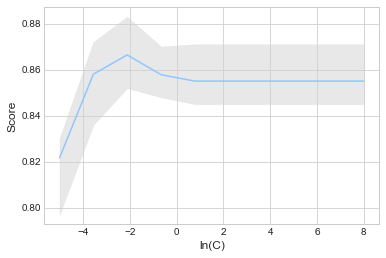

In [553]:
# Plotting results of the hyperparameter tuning cross-validation
custom_df = pd.DataFrame.from_dict(custom_search.cv_results_)
custom_params = [np.log(np.array(custom_df.param_C, dtype='float'))]
plot_cv_results(custom_df, 'ln(C)', custom_params)

3.1.2 Evaluate results of custom kernel SVM with the best hyperparameter values found

In [630]:
# plug in the best parameter found to test accuracy for test set

cus_sc = SVMClassifier(kernel='custom', C=0.12110333239232973, max_features=5000)
print("Training set")
cus_sc.fit(X_train, Y_train)
print("Testing set")
cus_pred = cus_sc.predict(X_test)
print(classification_report(Y_test, cus_pred))
print(accuracy_score(Y_test, cus_pred))

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.86      0.87      0.86       731
    positive       0.87      0.86      0.87       769

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500

0.864


In [ ]:
# Helper functions for results analysis

count = lambda data, to_count: sum([1 for x in data if x in to_count])

# 1. Number of tokens
def get_mean_len(X, Y, indices, sent):
    samples = [X[i] for i in indices if Y[i] == sent]
    samples = [nlp(review) for review in samples]
    return sum(len(review) for review in samples) / len(samples)

# 2. Number of punctuations
def get_mean_punc(X, Y, indices, sent):
    samples = [X[i] for i in indices if Y[i] == sent]
    c = 0
    ttl_len = 0
    for i in range(len(samples)):
        tokens = nlp(samples[i])
        c += count(review, set(string.punctuation))
        ttl_len += len(tokens)
    return (c / ttl_len) * 100

# 3. Number of words trimmed
def get_mean_trim(X, X_trim, Y, indices, sent):
    samples = [X[i] for i in indices if Y[i] == sent]
    trim_samples = [X_trim[i] for i in indices if Y[i] == sent]
    return (sum(((len(samples[i].split()) - len(trim_samples[i].split()))/len(samples[i].split())) \
               for i in range(len(samples))) / len(samples))*100


# 4. Number of adjectives
def get_mean_pos(X, Y, indices, sent, pos):
    samples = [X[i] for i in indices if Y[i] == sent]
    count = 0
    ttl_len = 0
    for i in range(len(samples)):
        tokens = nlp(samples[i])
        count += len([token for token in tokens if token.pos_ == pos])
        ttl_len += len(tokens)
    return count/len(samples)

# 5. Number of negation words
def get_mean_dep(X, Y, indices, sent, dep):
    samples = [X[i] for i in indices if Y[i] == sent]
    count = 0
    ttl_len = 0
    
    for i in range(len(samples)):
        tokens = nlp(samples[i])
        count += len([token for token in tokens if token.dep_ == dep])
        ttl_len += len(tokens)
        
    return (count/ttl_len)*100


In [632]:
cus_wrong_idx = [w for w in range(len(cus_pred)) if cus_pred[w] != Y_test[w]]
cus_correct_idx = [w for w in range(len(cus_pred)) if cus_pred[w] == Y_test[w]]

cus_raw_wrong_samples = [test.review[i] for i in wrong_idx]
cus_raw_correct_samples = [test.review[i] for i in correct_idx]

# 1. Number of tokens
cus_fn_mean_len = get_mean_len(X_test, Y_test, cus_wrong_idx, 'positive')
cus_fp_mean_len = get_mean_len(X_test, Y_test, cus_wrong_idx, 'negative')
cus_tn_mean_len = get_mean_len(X_test, Y_test, cus_correct_idx, 'negative')
cus_tp_mean_len = get_mean_len(X_test, Y_test, cus_correct_idx, 'positive')
print('Finished calculating ave length')

# 2. Number of punctuations
cus_fn_mean_punc = get_mean_punc(test.review, Y_test, cus_wrong_idx, 'positive')
cus_fp_mean_punc = get_mean_punc(test.review, Y_test, cus_wrong_idx, 'negative')
cus_tn_mean_punc = get_mean_punc(test.review, Y_test, cus_correct_idx, 'negative')
cus_tp_mean_punc = get_mean_punc(test.review, Y_test, cus_correct_idx, 'positive')
print('Finished calculating ave punctuations')

# 3. Ave % words trimmed
cus_fn_mean_trim = get_mean_trim(test.review, X_test, Y_test, cus_wrong_idx, 'positive')
cus_fp_mean_trim = get_mean_trim(test.review, X_test, Y_test, cus_wrong_idx, 'negative')
cus_tn_mean_trim = get_mean_trim(test.review, X_test, Y_test, cus_correct_idx, 'negative')
cus_tp_mean_trim = get_mean_trim(test.review, X_test, Y_test, cus_correct_idx, 'positive')
print('Finished calculating ave % words')

# 4. Number of negation words
cus_fn_mean_neg = get_mean_dep(test.review, Y_test, cus_wrong_idx, 'positive', 'neg')
cus_fp_mean_neg = get_mean_dep(test.review, Y_test, cus_wrong_idx, 'negative', 'neg')
cus_tn_mean_neg = get_mean_dep(test.review, Y_test, cus_correct_idx, 'negative', 'neg')
cus_tp_mean_neg = get_mean_dep(test.review, Y_test, cus_correct_idx, 'positive', 'neg')
print('Finished calculating ave negation words')


# 4. Number of adjectives
cus_fn_mean_adj = get_mean_pos(test.review, Y_test, cus_wrong_idx, 'positive', 'ADJ')
cus_fp_mean_adj = get_mean_pos(test.review, Y_test, cus_wrong_idx, 'negative', 'ADJ')
cus_tn_mean_adj = get_mean_pos(test.review, Y_test, cus_correct_idx, 'negative', 'ADJ')
cus_tp_mean_adj = get_mean_pos(test.review, Y_test, cus_correct_idx, 'positive', 'ADJ')
print('Finished calculating ave adjectives')


# Structure: FP, TP, FN, TN
labels = ['False Positive', 'True Positive', 'False Negative', 'True Negative']
cus_analysis = {'Punctuations': [cus_fp_mean_punc, cus_tp_mean_punc, cus_fn_mean_punc, cus_tn_mean_punc],
            'Adjectives': [cus_fp_mean_adj, cus_tp_mean_adj, cus_fn_mean_adj, cus_tn_mean_adj],
            'Negation Words': [cus_fp_mean_neg, cus_tp_mean_neg, cus_fn_mean_neg, cus_tn_mean_neg],
            'Tokens': [cus_fp_mean_len, poly_tp_mean_len, cus_fn_mean_len, cus_tn_mean_len],
            'Words Trimmed':  [cus_fp_mean_trim, cus_tp_mean_trim, cus_fn_mean_trim, cus_tn_mean_trim]
}

cus_analysis_df = pd.DataFrame(cus_analysis, index=labels)

cus_analysis_df.style.background_gradient(axis=0)

Finished calculating ave length
Finished calculating ave punctuations
Finished calculating ave % words
Finished calculating ave negation words
Finished calculating ave adjectives


,Punctuations,Adjectives,Negation Words,Tokens,Words Trimmed
False Positive,0.759837,19.010000,0.970000,106.180000,54.080000
True Positive,0.702200,21.860000,0.890000,117.110000,53.140000
False Negative,0.810243,17.160000,1.020000,100.590000,53.790000
True Negative,0.724746,20.210000,1.230000,113.500000,53.310000


### 3.2 SVM with linear kernel

3.2.1 Hyperparameter tuning (C)

In [525]:
# self testing code - remove before submission
# Hyperparameter tuning for linear kernel

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import math

C_rng = np.logspace(-5,8,20,base=math.e)

# Hyperparameter grid search with cross-validation

params_grid = {'kernel': ['linear'],
               'C': C_rng}

svc = svm.SVC()
linear_sc = SVMClassifier(kernel='linear')
linear_search = GridSearchCV(svc, params_grid, cv=5, verbose=10)
linear_X_train = linear_sc.vectorizer.fit_transform(X_train)
linear_search.fit(linear_X_train, Y_train)
print(linear_search.best_params_)
print(linear_search.best_estimator_)
print(linear_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START C=0.006737946999085469, kernel=linear......................
[CV 1/5; 1/20] END C=0.006737946999085469, kernel=linear;, score=0.506 total time=  15.8s
[CV 2/5; 1/20] START C=0.006737946999085469, kernel=linear......................
[CV 2/5; 1/20] END C=0.006737946999085469, kernel=linear;, score=0.506 total time=  15.2s
[CV 3/5; 1/20] START C=0.006737946999085469, kernel=linear......................
[CV 3/5; 1/20] END C=0.006737946999085469, kernel=linear;, score=0.506 total time=  16.4s
[CV 4/5; 1/20] START C=0.006737946999085469, kernel=linear......................
[CV 4/5; 1/20] END C=0.006737946999085469, kernel=linear;, score=0.507 total time=  15.8s
[CV 5/5; 1/20] START C=0.006737946999085469, kernel=linear......................
[CV 5/5; 1/20] END C=0.006737946999085469, kernel=linear;, score=0.507 total time=  17.1s
[CV 1/5; 2/20] START C=0.013356001111439869, kernel=linear......................
[C

[CV 4/5; 10/20] END C=3.1832246912598827, kernel=linear;, score=0.874 total time=  16.1s
[CV 5/5; 10/20] START C=3.1832246912598827, kernel=linear.......................
[CV 5/5; 10/20] END C=3.1832246912598827, kernel=linear;, score=0.873 total time=  15.6s
[CV 1/5; 11/20] START C=6.3098080943943815, kernel=linear.......................
[CV 1/5; 11/20] END C=6.3098080943943815, kernel=linear;, score=0.868 total time=  16.1s
[CV 2/5; 11/20] START C=6.3098080943943815, kernel=linear.......................
[CV 2/5; 11/20] END C=6.3098080943943815, kernel=linear;, score=0.876 total time=  14.4s
[CV 3/5; 11/20] START C=6.3098080943943815, kernel=linear.......................
[CV 3/5; 11/20] END C=6.3098080943943815, kernel=linear;, score=0.861 total time=  14.8s
[CV 4/5; 11/20] START C=6.3098080943943815, kernel=linear.......................
[CV 4/5; 11/20] END C=6.3098080943943815, kernel=linear;, score=0.874 total time=  14.5s
[CV 5/5; 11/20] START C=6.3098080943943815, kernel=linear....

[CV 3/5; 20/20] END C=2980.957987041727, kernel=linear;, score=0.861 total time=  14.5s
[CV 4/5; 20/20] START C=2980.957987041727, kernel=linear........................
[CV 4/5; 20/20] END C=2980.957987041727, kernel=linear;, score=0.874 total time=  13.9s
[CV 5/5; 20/20] START C=2980.957987041727, kernel=linear........................
[CV 5/5; 20/20] END C=2980.957987041727, kernel=linear;, score=0.873 total time=  13.1s
{'C': 0.8101577349324269, 'kernel': 'linear'}
SVC(C=0.8101577349324269, kernel='linear')
0.8806


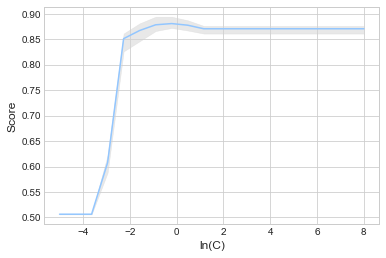

In [537]:
linear_df = pd.DataFrame.from_dict(linear_search.cv_results_)
linear_params = [np.log(np.array(linear_df.param_C, dtype='float'))]
plot_cv_results(linear_df, 'ln(C)', linear_params)

3.2.2 Evaluate results of linear kernel SVM with the best hyperparameter values found

In [625]:
# plug in the best parameter found to test accuracy for test set

linear_sc = SVMClassifier(kernel='linear', C=0.8101577349324269)
linear_sc.fit(X_train, Y_train)
linear_pred = linear_sc.predict(X_test)
print(classification_report(Y_test, linear_pred))

print(accuracy_score(Y_test, linear_pred))

              precision    recall  f1-score   support

    negative       0.87      0.88      0.88       731
    positive       0.89      0.87      0.88       769

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500

0.8786666666666667


3.2.2.1. Visualise the top and bottom ranked features

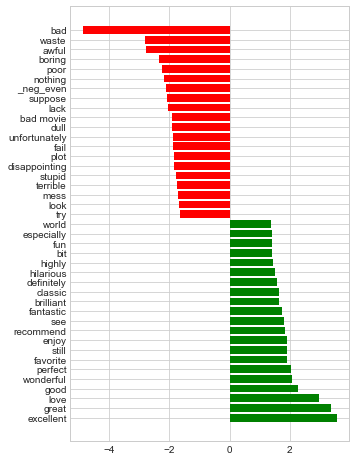

In [555]:
# visualize top features (only for linear svm classifiers)

from matplotlib import pyplot as plt
from sklearn import svm
from wordcloud import WordCloud

def visualize_importances(coef, names, top_features):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    pos_idx = -np.sort(-np.arange(len(imp)-top_features-1, len(imp)))
    neg_idx = -np.sort(-np.arange(0, top_features))
    show_idx = np.hstack([pos_idx, neg_idx])
    imp = [imp[i] for i in show_idx]
    names = [names[i] for i in show_idx]
    
    colors = ['red' if c < 0 else 'green' for c in imp]
    plt.figure(figsize=(5, 8))
    plt.barh(range(len(names)), imp, align='center', color=colors)
    plt.yticks(range(len(names)), names)
    plt.show()

def plot_wordcloud():
    # Display the generated image:
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
features_names = linear_sc.vectorizer.get_feature_names_out()
visualize_importances(linear_sc.clf.coef_.toarray()[0], features_names, top_features=20)


In [556]:
train_file = "movie_review_train.csv"
test_file = "movie_review_test.csv"

# Read the CSV files for training and test sets
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)



3.2.2.2. Most common words in misclassified samples

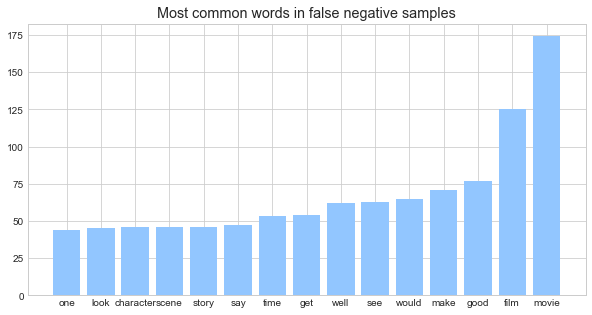

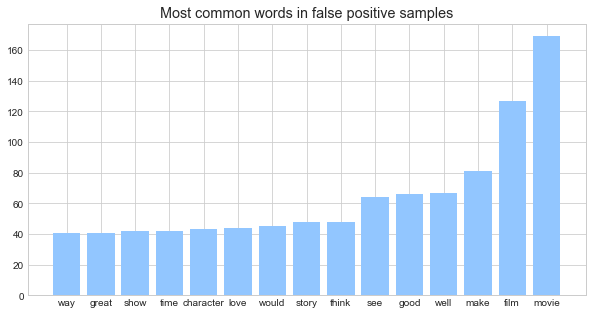

In [557]:
# find the most common words in misclassified samples and map the feature value
from nltk.tokenize import word_tokenize

def sorted_count(reviews):
    words = []
    for review in reviews:
        tokens = word_tokenize(review)
        for word in tokens:
            words.append(word)
    unique, counts = np.unique(np.array(words), return_counts=True)
    sorted_indices = np.argsort(counts)
    sorted_unique = unique[sorted_indices]
    sorted_counts = counts[sorted_indices]
    
    return sorted_unique, sorted_counts
    
fn_samples = [X_test[i] for i in wrong_idx if Y_test[i] == 'positive']
fp_samples = [X_test[i] for i in wrong_idx if Y_test[i] == 'negative']

fn_unique, fn_counts = sorted_count(fn_samples)
fp_unique, fp_counts = sorted_count(fp_samples)

plt.figure(figsize=(10, 5))
plt.title('Most common words in false negative samples')
plt.bar(fn_unique[-15:], fn_counts[-15:])
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Most common words in false positive samples')
plt.bar(fp_unique[-15:], fp_counts[-15:])
plt.show()


In [621]:
wrong_idx = [w for w in range(len(linear_pred)) if linear_pred[w] != Y_test[w]]
correct_idx = [w for w in range(len(linear_pred)) if linear_pred[w] == Y_test[w]]

raw_wrong_samples = [test.review[i] for i in wrong_idx]
raw_correct_samples = [test.review[i] for i in correct_idx]

# 1. Ave length
fn_mean_len = get_mean_len(X_test, Y_test, wrong_idx, 'positive')
fp_mean_len = get_mean_len(X_test, Y_test, wrong_idx, 'negative')
tn_mean_len = get_mean_len(X_test, Y_test, correct_idx, 'negative')
tp_mean_len = get_mean_len(X_test, Y_test, correct_idx, 'positive')
print('Finished calculating ave length')

# 2. Ave % punctuations
fn_mean_punc = get_mean_punc(test.review, Y_test, wrong_idx, 'positive')
fp_mean_punc = get_mean_punc(test.review, Y_test, wrong_idx, 'negative')
tn_mean_punc = get_mean_punc(test.review, Y_test, correct_idx, 'negative')
tp_mean_punc = get_mean_punc(test.review, Y_test, correct_idx, 'positive')
print('Finished calculating ave % punctuations')

# 3. Ave % words trimmed
fn_mean_trim = get_mean_trim(test.review, X_test, Y_test, wrong_idx, 'positive')
fp_mean_trim = get_mean_trim(test.review, X_test, Y_test, wrong_idx, 'negative')
tn_mean_trim = get_mean_trim(test.review, X_test, Y_test, correct_idx, 'negative')
tp_mean_trim = get_mean_trim(test.review, X_test, Y_test, correct_idx, 'positive')
print('Finished calculating ave % words')

# 4. Ave % negation words
fn_mean_neg = get_mean_dep(test.review, Y_test, wrong_idx, 'positive', 'neg')
fp_mean_neg = get_mean_dep(test.review, Y_test, wrong_idx, 'negative', 'neg')
tn_mean_neg = get_mean_dep(test.review, Y_test, correct_idx, 'negative', 'neg')
tp_mean_neg = get_mean_dep(test.review, Y_test, correct_idx, 'positive', 'neg')
print('Finished calculating ave % negation words')

# 5. Ave % adjectives
fn_mean_adj = get_mean_pos(test.review, Y_test, wrong_idx, 'positive', 'ADJ')
fp_mean_adj = get_mean_pos(test.review, Y_test, wrong_idx, 'negative', 'ADJ')
tn_mean_adj = get_mean_pos(test.review, Y_test, correct_idx, 'negative', 'ADJ')
tp_mean_adj = get_mean_pos(test.review, Y_test, correct_idx, 'positive', 'ADJ')
print('Finished calculating ave % adjectives')

# Structure: FP, TP, FN, TN
labels = ['False Positive', 'True Positive', 'False Negative', 'True Negative']
analysis = {'Punctuations': [fp_mean_punc, tp_mean_punc, fn_mean_punc, tn_mean_punc],
            'Adjectives': [fp_mean_adj, tp_mean_adj, fn_mean_adj, tn_mean_adj],
            'Negation Words': [fp_mean_neg, tp_mean_neg, fn_mean_neg, tn_mean_neg],
            'Tokens': [fp_mean_len, tp_mean_len, fn_mean_len, tn_mean_len],
            'Words Trimmed':  [fp_mean_trim, tp_mean_trim, fn_mean_trim, tn_mean_trim]
}

analysis_df = pd.DataFrame(analysis, index=labels)

analysis_df.style.background_gradient(axis=0)

Finished calculating ave length
Finished calculating ave % punctuations
Finished calculating ave % words
Finished calculating ave % negation words
Finished calculating ave % adjectives


,Punctuations,Adjectives,Negation Words,Tokens,Words Trimmed
False Positive,0.790918,18.530000,1.000000,102.690000,53.670000
True Positive,0.706090,21.630000,0.870000,117.110000,53.090000
False Negative,0.786827,18.300000,1.130000,102.740000,54.170000
True Negative,0.721856,20.250000,1.220000,113.820000,53.380000


### 3.3 SVM with RBF Kernel

3.3.1. Hyperparameter tuning (C, Gamma)

In [527]:
from sklearn.metrics import classification_report

# Hyperparameter tuning
C_rng = np.logspace(-5,8,20,base=math.e)
gamma_rng = np.logspace(-5,8,20,base=math.e)

params_grid = {'kernel':['rbf'],
               'C': C_rng,
              'gamma': gamma_rng}

rbf_svc = svm.SVC()
rbf_sc = SVMClassifier(kernel='rbf')
rbf_search = GridSearchCV(rbf_svc, params_grid, cv=5, verbose=10)
rbf_X_train = rbf_sc.vectorizer.fit_transform(X_train)
rbf_search.fit(rbf_X_train, Y_train)
print(rbf_search.best_params_)
print(rbf_search.best_estimator_)
print(rbf_search.best_score_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV 1/5; 1/400] START C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf
[CV 1/5; 1/400] END C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  15.7s
[CV 2/5; 1/400] START C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf
[CV 2/5; 1/400] END C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  16.0s
[CV 3/5; 1/400] START C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf
[CV 3/5; 1/400] END C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  15.9s
[CV 4/5; 1/400] START C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf
[CV 4/5; 1/400] END C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf;, score=0.507 total time=  16.6s
[CV 5/5; 1/400] START C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf
[CV 5/5; 1/400] END C=0.006737946999085469, gam

[CV 2/5; 9/400] END C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf;, score=0.506 total time=  14.5s
[CV 3/5; 9/400] START C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf
[CV 3/5; 9/400] END C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf;, score=0.506 total time=  15.9s
[CV 4/5; 9/400] START C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf
[CV 4/5; 9/400] END C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf;, score=0.507 total time=  16.7s
[CV 5/5; 9/400] START C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf
[CV 5/5; 9/400] END C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf;, score=0.507 total time=  16.6s
[CV 1/5; 10/400] START C=0.006737946999085469, gamma=3.1832246912598827, kernel=rbf
[CV 1/5; 10/400] END C=0.006737946999085469, gamma=3.1832246912598827, kernel=rbf;, score=0.506 total time=  16.7s
[CV 2/5; 10/400] START C=0.006737946999085469, gamma=3.1832246912598827, kernel=rbf
[CV 2/5; 10/

[CV 4/5; 17/400] END C=0.006737946999085469, gamma=382.7447894740212, kernel=rbf;, score=0.507 total time=  17.4s
[CV 5/5; 17/400] START C=0.006737946999085469, gamma=382.7447894740212, kernel=rbf
[CV 5/5; 17/400] END C=0.006737946999085469, gamma=382.7447894740212, kernel=rbf;, score=0.507 total time=  17.0s
[CV 1/5; 18/400] START C=0.006737946999085469, gamma=758.679139848782, kernel=rbf
[CV 1/5; 18/400] END C=0.006737946999085469, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  16.5s
[CV 2/5; 18/400] START C=0.006737946999085469, gamma=758.679139848782, kernel=rbf
[CV 2/5; 18/400] END C=0.006737946999085469, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  16.8s
[CV 3/5; 18/400] START C=0.006737946999085469, gamma=758.679139848782, kernel=rbf
[CV 3/5; 18/400] END C=0.006737946999085469, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  14.7s
[CV 4/5; 18/400] START C=0.006737946999085469, gamma=758.679139848782, kernel=rbf
[CV 4/5; 18/400] END C

[CV 5/5; 25/400] END C=0.013356001111439869, gamma=0.10402147666803764, kernel=rbf;, score=0.507 total time=  16.3s
[CV 1/5; 26/400] START C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf
[CV 1/5; 26/400] END C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf;, score=0.506 total time=  16.4s
[CV 2/5; 26/400] START C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf
[CV 2/5; 26/400] END C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf;, score=0.506 total time=  16.6s
[CV 3/5; 26/400] START C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf
[CV 3/5; 26/400] END C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf;, score=0.506 total time=  16.5s
[CV 4/5; 26/400] START C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf
[CV 4/5; 26/400] END C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf;, score=0.507 total time=  16.3s
[CV 5/5; 26/400] START C=0.013356001111439869, gamma=0.20619202825140895, kernel

[CV 2/5; 34/400] END C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  14.8s
[CV 3/5; 34/400] START C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf
[CV 3/5; 34/400] END C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  16.5s
[CV 4/5; 34/400] START C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf
[CV 4/5; 34/400] END C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  16.2s
[CV 5/5; 34/400] START C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf
[CV 5/5; 34/400] END C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  14.3s
[CV 1/5; 35/400] START C=0.013356001111439869, gamma=97.41180148195387, kernel=rbf
[CV 1/5; 35/400] END C=0.013356001111439869, gamma=97.41180148195387, kernel=rbf;, score=0.506 total time=  14.3s
[CV 2/5; 35/400] START C=0.013356001111439869, gamma=97.41180148195387, kernel=rbf
[CV 2/5;

[CV 4/5; 42/400] END C=0.026474349785326985, gamma=0.013356001111439869, kernel=rbf;, score=0.507 total time=  16.4s
[CV 5/5; 42/400] START C=0.026474349785326985, gamma=0.013356001111439869, kernel=rbf
[CV 5/5; 42/400] END C=0.026474349785326985, gamma=0.013356001111439869, kernel=rbf;, score=0.507 total time=  16.2s
[CV 1/5; 43/400] START C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf
[CV 1/5; 43/400] END C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf;, score=0.506 total time=  16.4s
[CV 2/5; 43/400] START C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf
[CV 2/5; 43/400] END C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf;, score=0.506 total time=  16.6s
[CV 3/5; 43/400] START C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf
[CV 3/5; 43/400] END C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf;, score=0.506 total time=  16.3s
[CV 4/5; 43/400] START C=0.026474349785326985, gamma=0.0264743497853269

[CV 5/5; 50/400] END C=0.026474349785326985, gamma=3.1832246912598827, kernel=rbf;, score=0.507 total time=  16.5s
[CV 1/5; 51/400] START C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf
[CV 1/5; 51/400] END C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  16.7s
[CV 2/5; 51/400] START C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf
[CV 2/5; 51/400] END C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  16.7s
[CV 3/5; 51/400] START C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf
[CV 3/5; 51/400] END C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  16.4s
[CV 4/5; 51/400] START C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf
[CV 4/5; 51/400] END C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf;, score=0.507 total time=  16.5s
[CV 5/5; 51/400] START C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf
[CV 5

[CV 2/5; 59/400] END C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  15.8s
[CV 3/5; 59/400] START C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf
[CV 3/5; 59/400] END C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  15.3s
[CV 4/5; 59/400] START C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf
[CV 4/5; 59/400] END C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf;, score=0.507 total time=  14.3s
[CV 5/5; 59/400] START C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf
[CV 5/5; 59/400] END C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf;, score=0.507 total time=  15.2s
[CV 1/5; 60/400] START C=0.026474349785326985, gamma=2980.957987041727, kernel=rbf
[CV 1/5; 60/400] END C=0.026474349785326985, gamma=2980.957987041727, kernel=rbf;, score=0.506 total time=  16.0s
[CV 2/5; 60/400] START C=0.026474349785326985, gamma=2980.957987041727, kernel=rbf
[CV 2/5;

[CV 3/5; 67/400] END C=0.052477623407466346, gamma=0.40871514110598417, kernel=rbf;, score=0.506 total time=  16.2s
[CV 4/5; 67/400] START C=0.052477623407466346, gamma=0.40871514110598417, kernel=rbf
[CV 4/5; 67/400] END C=0.052477623407466346, gamma=0.40871514110598417, kernel=rbf;, score=0.507 total time=  16.6s
[CV 5/5; 67/400] START C=0.052477623407466346, gamma=0.40871514110598417, kernel=rbf
[CV 5/5; 67/400] END C=0.052477623407466346, gamma=0.40871514110598417, kernel=rbf;, score=0.507 total time=  16.5s
[CV 1/5; 68/400] START C=0.052477623407466346, gamma=0.8101577349324269, kernel=rbf
[CV 1/5; 68/400] END C=0.052477623407466346, gamma=0.8101577349324269, kernel=rbf;, score=0.506 total time=  16.5s
[CV 2/5; 68/400] START C=0.052477623407466346, gamma=0.8101577349324269, kernel=rbf
[CV 2/5; 68/400] END C=0.052477623407466346, gamma=0.8101577349324269, kernel=rbf;, score=0.506 total time=  16.6s
[CV 3/5; 68/400] START C=0.052477623407466346, gamma=0.8101577349324269, kernel=rbf


[CV 5/5; 75/400] END C=0.052477623407466346, gamma=97.41180148195387, kernel=rbf;, score=0.507 total time=  16.1s
[CV 1/5; 76/400] START C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf
[CV 1/5; 76/400] END C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf;, score=0.506 total time=  14.9s
[CV 2/5; 76/400] START C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf
[CV 2/5; 76/400] END C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf;, score=0.506 total time=  16.8s
[CV 3/5; 76/400] START C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf
[CV 3/5; 76/400] END C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf;, score=0.506 total time=  16.4s
[CV 4/5; 76/400] START C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf
[CV 4/5; 76/400] END C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf;, score=0.507 total time=  16.6s
[CV 5/5; 76/400] START C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf
[CV 5/5; 76/400

[CV 2/5; 84/400] END C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf;, score=0.506 total time=  16.2s
[CV 3/5; 84/400] START C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf
[CV 3/5; 84/400] END C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf;, score=0.506 total time=  16.3s
[CV 4/5; 84/400] START C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf
[CV 4/5; 84/400] END C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf;, score=0.507 total time=  14.8s
[CV 5/5; 84/400] START C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf
[CV 5/5; 84/400] END C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf;, score=0.507 total time=  16.2s
[CV 1/5; 85/400] START C=0.10402147666803764, gamma=0.10402147666803764, kernel=rbf
[CV 1/5; 85/400] END C=0.10402147666803764, gamma=0.10402147666803764, kernel=rbf;, score=0.506 total time=  16.4s
[CV 2/5; 85/400] START C=0.10402147666803764, gamma=0.10402147666803764, kernel=rb

[CV 4/5; 92/400] END C=0.10402147666803764, gamma=12.507341469611143, kernel=rbf;, score=0.507 total time=  16.1s
[CV 5/5; 92/400] START C=0.10402147666803764, gamma=12.507341469611143, kernel=rbf
[CV 5/5; 92/400] END C=0.10402147666803764, gamma=12.507341469611143, kernel=rbf;, score=0.507 total time=  15.3s
[CV 1/5; 93/400] START C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf
[CV 1/5; 93/400] END C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf;, score=0.506 total time=  16.0s
[CV 2/5; 93/400] START C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf
[CV 2/5; 93/400] END C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf;, score=0.506 total time=  14.9s
[CV 3/5; 93/400] START C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf
[CV 3/5; 93/400] END C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf;, score=0.506 total time=  16.2s
[CV 4/5; 93/400] START C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf
[CV 4/5; 93/400

[CV 1/5; 101/400] END C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  16.3s
[CV 2/5; 101/400] START C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf
[CV 2/5; 101/400] END C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  16.8s
[CV 3/5; 101/400] START C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf
[CV 3/5; 101/400] END C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  16.5s
[CV 4/5; 101/400] START C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf
[CV 4/5; 101/400] END C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf;, score=0.507 total time=  16.4s
[CV 5/5; 101/400] START C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf
[CV 5/5; 101/400] END C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf;, score=0.507 total time=  16.3s
[CV 1/5; 102/400] START C=0.20619202825140895, gamma=0.0133560011114398

[CV 2/5; 109/400] END C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf;, score=0.506 total time=  16.6s
[CV 3/5; 109/400] START C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf
[CV 3/5; 109/400] END C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf;, score=0.506 total time=  16.6s
[CV 4/5; 109/400] START C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf
[CV 4/5; 109/400] END C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf;, score=0.507 total time=  16.8s
[CV 5/5; 109/400] START C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf
[CV 5/5; 109/400] END C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf;, score=0.507 total time=  16.5s
[CV 1/5; 110/400] START C=0.20619202825140895, gamma=3.1832246912598827, kernel=rbf
[CV 1/5; 110/400] END C=0.20619202825140895, gamma=3.1832246912598827, kernel=rbf;, score=0.506 total time=  16.6s
[CV 2/5; 110/400] START C=0.20619202825140895, gamma=3.1832246912598827, kernel=rbf
[CV 2

[CV 4/5; 117/400] END C=0.20619202825140895, gamma=382.7447894740212, kernel=rbf;, score=0.507 total time=  15.1s
[CV 5/5; 117/400] START C=0.20619202825140895, gamma=382.7447894740212, kernel=rbf
[CV 5/5; 117/400] END C=0.20619202825140895, gamma=382.7447894740212, kernel=rbf;, score=0.507 total time=  16.1s
[CV 1/5; 118/400] START C=0.20619202825140895, gamma=758.679139848782, kernel=rbf
[CV 1/5; 118/400] END C=0.20619202825140895, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  16.2s
[CV 2/5; 118/400] START C=0.20619202825140895, gamma=758.679139848782, kernel=rbf
[CV 2/5; 118/400] END C=0.20619202825140895, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  16.7s
[CV 3/5; 118/400] START C=0.20619202825140895, gamma=758.679139848782, kernel=rbf
[CV 3/5; 118/400] END C=0.20619202825140895, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  15.9s
[CV 4/5; 118/400] START C=0.20619202825140895, gamma=758.679139848782, kernel=rbf
[CV 4/5; 118/400] END 

[CV 5/5; 125/400] END C=0.40871514110598417, gamma=0.10402147666803764, kernel=rbf;, score=0.837 total time=  16.3s
[CV 1/5; 126/400] START C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf
[CV 1/5; 126/400] END C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf;, score=0.863 total time=  15.9s
[CV 2/5; 126/400] START C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf
[CV 2/5; 126/400] END C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf;, score=0.852 total time=  15.9s
[CV 3/5; 126/400] START C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf
[CV 3/5; 126/400] END C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf;, score=0.831 total time=  15.6s
[CV 4/5; 126/400] START C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf
[CV 4/5; 126/400] END C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf;, score=0.859 total time=  15.8s
[CV 5/5; 126/400] START C=0.40871514110598417, gamma=0.20619202825140895, kernel

[CV 2/5; 134/400] END C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  16.1s
[CV 3/5; 134/400] START C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf
[CV 3/5; 134/400] END C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  16.5s
[CV 4/5; 134/400] START C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf
[CV 4/5; 134/400] END C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  16.6s
[CV 5/5; 134/400] START C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf
[CV 5/5; 134/400] END C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  16.5s
[CV 1/5; 135/400] START C=0.40871514110598417, gamma=97.41180148195387, kernel=rbf
[CV 1/5; 135/400] END C=0.40871514110598417, gamma=97.41180148195387, kernel=rbf;, score=0.506 total time=  16.7s
[CV 2/5; 135/400] START C=0.40871514110598417, gamma=97.41180148195387, kernel=rbf
[CV 2/5;

[CV 4/5; 142/400] END C=0.8101577349324269, gamma=0.013356001111439869, kernel=rbf;, score=0.507 total time=  16.5s
[CV 5/5; 142/400] START C=0.8101577349324269, gamma=0.013356001111439869, kernel=rbf
[CV 5/5; 142/400] END C=0.8101577349324269, gamma=0.013356001111439869, kernel=rbf;, score=0.507 total time=  16.5s
[CV 1/5; 143/400] START C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf
[CV 1/5; 143/400] END C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf;, score=0.507 total time=  16.5s
[CV 2/5; 143/400] START C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf
[CV 2/5; 143/400] END C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf;, score=0.512 total time=  16.6s
[CV 3/5; 143/400] START C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf
[CV 3/5; 143/400] END C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf;, score=0.507 total time=  16.2s
[CV 4/5; 143/400] START C=0.8101577349324269, gamma=0.026474349785326985, kernel

[CV 1/5; 151/400] END C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  16.5s
[CV 2/5; 151/400] START C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf
[CV 2/5; 151/400] END C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf;, score=0.509 total time=  16.8s
[CV 3/5; 151/400] START C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf
[CV 3/5; 151/400] END C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf;, score=0.507 total time=  16.6s
[CV 4/5; 151/400] START C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf
[CV 4/5; 151/400] END C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf;, score=0.508 total time=  16.7s
[CV 5/5; 151/400] START C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf
[CV 5/5; 151/400] END C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf;, score=0.508 total time=  16.6s
[CV 1/5; 152/400] START C=0.8101577349324269, gamma=12.507341469611143, kernel=rbf
[CV 1/5; 152/40

[CV 3/5; 159/400] END C=0.8101577349324269, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  16.6s
[CV 4/5; 159/400] START C=0.8101577349324269, gamma=1503.8585842871576, kernel=rbf
[CV 4/5; 159/400] END C=0.8101577349324269, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  16.8s
[CV 5/5; 159/400] START C=0.8101577349324269, gamma=1503.8585842871576, kernel=rbf
[CV 5/5; 159/400] END C=0.8101577349324269, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  16.4s
[CV 1/5; 160/400] START C=0.8101577349324269, gamma=2980.957987041727, kernel=rbf
[CV 1/5; 160/400] END C=0.8101577349324269, gamma=2980.957987041727, kernel=rbf;, score=0.506 total time=  15.5s
[CV 2/5; 160/400] START C=0.8101577349324269, gamma=2980.957987041727, kernel=rbf
[CV 2/5; 160/400] END C=0.8101577349324269, gamma=2980.957987041727, kernel=rbf;, score=0.508 total time=  14.5s
[CV 3/5; 160/400] START C=0.8101577349324269, gamma=2980.957987041727, kernel=rbf
[CV 3/5; 160/400] EN

[CV 5/5; 167/400] END C=1.6058997806999291, gamma=0.40871514110598417, kernel=rbf;, score=0.898 total time=  12.6s
[CV 1/5; 168/400] START C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf
[CV 1/5; 168/400] END C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf;, score=0.875 total time=  15.5s
[CV 2/5; 168/400] START C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf
[CV 2/5; 168/400] END C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf;, score=0.886 total time=  16.1s
[CV 3/5; 168/400] START C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf
[CV 3/5; 168/400] END C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf;, score=0.870 total time=  15.9s
[CV 4/5; 168/400] START C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf
[CV 4/5; 168/400] END C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf;, score=0.884 total time=  16.1s
[CV 5/5; 168/400] START C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf
[CV 5/5; 168/4

[CV 2/5; 176/400] END C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf;, score=0.509 total time=  16.7s
[CV 3/5; 176/400] START C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf
[CV 3/5; 176/400] END C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf;, score=0.507 total time=  16.6s
[CV 4/5; 176/400] START C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf
[CV 4/5; 176/400] END C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  16.9s
[CV 5/5; 176/400] START C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf
[CV 5/5; 176/400] END C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  16.9s
[CV 1/5; 177/400] START C=1.6058997806999291, gamma=382.7447894740212, kernel=rbf
[CV 1/5; 177/400] END C=1.6058997806999291, gamma=382.7447894740212, kernel=rbf;, score=0.506 total time=  17.3s
[CV 2/5; 177/400] START C=1.6058997806999291, gamma=382.7447894740212, kernel=rbf
[CV 2/5; 177/400] END C=1

[CV 4/5; 184/400] END C=3.1832246912598827, gamma=0.052477623407466346, kernel=rbf;, score=0.877 total time=  13.8s
[CV 5/5; 184/400] START C=3.1832246912598827, gamma=0.052477623407466346, kernel=rbf
[CV 5/5; 184/400] END C=3.1832246912598827, gamma=0.052477623407466346, kernel=rbf;, score=0.890 total time=  13.6s
[CV 1/5; 185/400] START C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf
[CV 1/5; 185/400] END C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf;, score=0.881 total time=  12.9s
[CV 2/5; 185/400] START C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf
[CV 2/5; 185/400] END C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf;, score=0.883 total time=  12.8s
[CV 3/5; 185/400] START C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf
[CV 3/5; 185/400] END C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf;, score=0.869 total time=  12.3s
[CV 4/5; 185/400] START C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf
[C

[CV 1/5; 193/400] END C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf;, score=0.506 total time=  16.8s
[CV 2/5; 193/400] START C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf
[CV 2/5; 193/400] END C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf;, score=0.509 total time=  16.8s
[CV 3/5; 193/400] START C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf
[CV 3/5; 193/400] END C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf;, score=0.507 total time=  16.6s
[CV 4/5; 193/400] START C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf
[CV 4/5; 193/400] END C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf;, score=0.508 total time=  16.8s
[CV 5/5; 193/400] START C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf
[CV 5/5; 193/400] END C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf;, score=0.508 total time=  16.8s
[CV 1/5; 194/400] START C=3.1832246912598827, gamma=49.143119261097524, kernel=rbf
[CV 1/5; 194/40

[CV 3/5; 201/400] END C=6.3098080943943815, gamma=0.006737946999085469, kernel=rbf;, score=0.836 total time=  16.4s
[CV 4/5; 201/400] START C=6.3098080943943815, gamma=0.006737946999085469, kernel=rbf
[CV 4/5; 201/400] END C=6.3098080943943815, gamma=0.006737946999085469, kernel=rbf;, score=0.856 total time=  16.4s
[CV 5/5; 201/400] START C=6.3098080943943815, gamma=0.006737946999085469, kernel=rbf
[CV 5/5; 201/400] END C=6.3098080943943815, gamma=0.006737946999085469, kernel=rbf;, score=0.869 total time=  16.3s
[CV 1/5; 202/400] START C=6.3098080943943815, gamma=0.013356001111439869, kernel=rbf
[CV 1/5; 202/400] END C=6.3098080943943815, gamma=0.013356001111439869, kernel=rbf;, score=0.862 total time=  14.5s
[CV 2/5; 202/400] START C=6.3098080943943815, gamma=0.013356001111439869, kernel=rbf
[CV 2/5; 202/400] END C=6.3098080943943815, gamma=0.013356001111439869, kernel=rbf;, score=0.860 total time=  15.3s
[CV 3/5; 202/400] START C=6.3098080943943815, gamma=0.013356001111439869, kernel

[CV 5/5; 209/400] END C=6.3098080943943815, gamma=1.6058997806999291, kernel=rbf;, score=0.888 total time=  16.6s
[CV 1/5; 210/400] START C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf
[CV 1/5; 210/400] END C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf;, score=0.861 total time=  16.8s
[CV 2/5; 210/400] START C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf
[CV 2/5; 210/400] END C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf;, score=0.865 total time=  16.7s
[CV 3/5; 210/400] START C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf
[CV 3/5; 210/400] END C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf;, score=0.848 total time=  16.7s
[CV 4/5; 210/400] START C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf
[CV 4/5; 210/400] END C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf;, score=0.850 total time=  16.9s
[CV 5/5; 210/400] START C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf
[CV 5/5; 210/40

[CV 2/5; 218/400] END C=6.3098080943943815, gamma=758.679139848782, kernel=rbf;, score=0.508 total time=  16.8s
[CV 3/5; 218/400] START C=6.3098080943943815, gamma=758.679139848782, kernel=rbf
[CV 3/5; 218/400] END C=6.3098080943943815, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  16.9s
[CV 4/5; 218/400] START C=6.3098080943943815, gamma=758.679139848782, kernel=rbf
[CV 4/5; 218/400] END C=6.3098080943943815, gamma=758.679139848782, kernel=rbf;, score=0.508 total time=  16.8s
[CV 5/5; 218/400] START C=6.3098080943943815, gamma=758.679139848782, kernel=rbf
[CV 5/5; 218/400] END C=6.3098080943943815, gamma=758.679139848782, kernel=rbf;, score=0.508 total time=  16.8s
[CV 1/5; 219/400] START C=6.3098080943943815, gamma=1503.8585842871576, kernel=rbf
[CV 1/5; 219/400] END C=6.3098080943943815, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  16.8s
[CV 2/5; 219/400] START C=6.3098080943943815, gamma=1503.8585842871576, kernel=rbf
[CV 2/5; 219/400] END C=6.309

[CV 4/5; 226/400] END C=12.507341469611143, gamma=0.20619202825140895, kernel=rbf;, score=0.880 total time=  14.8s
[CV 5/5; 226/400] START C=12.507341469611143, gamma=0.20619202825140895, kernel=rbf
[CV 5/5; 226/400] END C=12.507341469611143, gamma=0.20619202825140895, kernel=rbf;, score=0.884 total time=  14.7s
[CV 1/5; 227/400] START C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf
[CV 1/5; 227/400] END C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf;, score=0.872 total time=  15.3s
[CV 2/5; 227/400] START C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf
[CV 2/5; 227/400] END C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf;, score=0.880 total time=  15.6s
[CV 3/5; 227/400] START C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf
[CV 3/5; 227/400] END C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf;, score=0.868 total time=  15.0s
[CV 4/5; 227/400] START C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf
[CV 4

[CV 1/5; 235/400] END C=12.507341469611143, gamma=97.41180148195387, kernel=rbf;, score=0.506 total time=  16.8s
[CV 2/5; 235/400] START C=12.507341469611143, gamma=97.41180148195387, kernel=rbf
[CV 2/5; 235/400] END C=12.507341469611143, gamma=97.41180148195387, kernel=rbf;, score=0.509 total time=  17.0s
[CV 3/5; 235/400] START C=12.507341469611143, gamma=97.41180148195387, kernel=rbf
[CV 3/5; 235/400] END C=12.507341469611143, gamma=97.41180148195387, kernel=rbf;, score=0.507 total time=  16.8s
[CV 4/5; 235/400] START C=12.507341469611143, gamma=97.41180148195387, kernel=rbf
[CV 4/5; 235/400] END C=12.507341469611143, gamma=97.41180148195387, kernel=rbf;, score=0.508 total time=  16.9s
[CV 5/5; 235/400] START C=12.507341469611143, gamma=97.41180148195387, kernel=rbf
[CV 5/5; 235/400] END C=12.507341469611143, gamma=97.41180148195387, kernel=rbf;, score=0.508 total time=  16.8s
[CV 1/5; 236/400] START C=12.507341469611143, gamma=193.0902883381129, kernel=rbf
[CV 1/5; 236/400] END C=1

[CV 3/5; 243/400] END C=24.792131281525027, gamma=0.026474349785326985, kernel=rbf;, score=0.867 total time=  11.8s
[CV 4/5; 243/400] START C=24.792131281525027, gamma=0.026474349785326985, kernel=rbf
[CV 4/5; 243/400] END C=24.792131281525027, gamma=0.026474349785326985, kernel=rbf;, score=0.881 total time=  11.9s
[CV 5/5; 243/400] START C=24.792131281525027, gamma=0.026474349785326985, kernel=rbf
[CV 5/5; 243/400] END C=24.792131281525027, gamma=0.026474349785326985, kernel=rbf;, score=0.886 total time=  11.9s
[CV 1/5; 244/400] START C=24.792131281525027, gamma=0.052477623407466346, kernel=rbf
[CV 1/5; 244/400] END C=24.792131281525027, gamma=0.052477623407466346, kernel=rbf;, score=0.870 total time=  12.4s
[CV 2/5; 244/400] START C=24.792131281525027, gamma=0.052477623407466346, kernel=rbf
[CV 2/5; 244/400] END C=24.792131281525027, gamma=0.052477623407466346, kernel=rbf;, score=0.878 total time=  12.7s
[CV 3/5; 244/400] START C=24.792131281525027, gamma=0.052477623407466346, kernel

[CV 5/5; 251/400] END C=24.792131281525027, gamma=6.3098080943943815, kernel=rbf;, score=0.508 total time=  16.9s
[CV 1/5; 252/400] START C=24.792131281525027, gamma=12.507341469611143, kernel=rbf
[CV 1/5; 252/400] END C=24.792131281525027, gamma=12.507341469611143, kernel=rbf;, score=0.506 total time=  17.0s
[CV 2/5; 252/400] START C=24.792131281525027, gamma=12.507341469611143, kernel=rbf
[CV 2/5; 252/400] END C=24.792131281525027, gamma=12.507341469611143, kernel=rbf;, score=0.509 total time=  16.8s
[CV 3/5; 252/400] START C=24.792131281525027, gamma=12.507341469611143, kernel=rbf
[CV 3/5; 252/400] END C=24.792131281525027, gamma=12.507341469611143, kernel=rbf;, score=0.507 total time=  16.7s
[CV 4/5; 252/400] START C=24.792131281525027, gamma=12.507341469611143, kernel=rbf
[CV 4/5; 252/400] END C=24.792131281525027, gamma=12.507341469611143, kernel=rbf;, score=0.508 total time=  16.9s
[CV 5/5; 252/400] START C=24.792131281525027, gamma=12.507341469611143, kernel=rbf
[CV 5/5; 252/40

[CV 2/5; 260/400] END C=24.792131281525027, gamma=2980.957987041727, kernel=rbf;, score=0.508 total time=  16.9s
[CV 3/5; 260/400] START C=24.792131281525027, gamma=2980.957987041727, kernel=rbf
[CV 3/5; 260/400] END C=24.792131281525027, gamma=2980.957987041727, kernel=rbf;, score=0.506 total time=  16.7s
[CV 4/5; 260/400] START C=24.792131281525027, gamma=2980.957987041727, kernel=rbf
[CV 4/5; 260/400] END C=24.792131281525027, gamma=2980.957987041727, kernel=rbf;, score=0.508 total time=  16.9s
[CV 5/5; 260/400] START C=24.792131281525027, gamma=2980.957987041727, kernel=rbf
[CV 5/5; 260/400] END C=24.792131281525027, gamma=2980.957987041727, kernel=rbf;, score=0.508 total time=  17.0s
[CV 1/5; 261/400] START C=49.143119261097524, gamma=0.006737946999085469, kernel=rbf
[CV 1/5; 261/400] END C=49.143119261097524, gamma=0.006737946999085469, kernel=rbf;, score=0.877 total time=  12.2s
[CV 2/5; 261/400] START C=49.143119261097524, gamma=0.006737946999085469, kernel=rbf
[CV 2/5; 261/400

[CV 4/5; 268/400] END C=49.143119261097524, gamma=0.8101577349324269, kernel=rbf;, score=0.884 total time=  16.2s
[CV 5/5; 268/400] START C=49.143119261097524, gamma=0.8101577349324269, kernel=rbf
[CV 5/5; 268/400] END C=49.143119261097524, gamma=0.8101577349324269, kernel=rbf;, score=0.895 total time=  16.1s
[CV 1/5; 269/400] START C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf
[CV 1/5; 269/400] END C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf;, score=0.871 total time=  16.9s
[CV 2/5; 269/400] START C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf
[CV 2/5; 269/400] END C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf;, score=0.876 total time=  16.9s
[CV 3/5; 269/400] START C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf
[CV 3/5; 269/400] END C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf;, score=0.861 total time=  16.6s
[CV 4/5; 269/400] START C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf
[CV 4/5; 269/40

[CV 1/5; 277/400] END C=49.143119261097524, gamma=382.7447894740212, kernel=rbf;, score=0.506 total time=  17.4s
[CV 2/5; 277/400] START C=49.143119261097524, gamma=382.7447894740212, kernel=rbf
[CV 2/5; 277/400] END C=49.143119261097524, gamma=382.7447894740212, kernel=rbf;, score=0.508 total time=  17.5s
[CV 3/5; 277/400] START C=49.143119261097524, gamma=382.7447894740212, kernel=rbf
[CV 3/5; 277/400] END C=49.143119261097524, gamma=382.7447894740212, kernel=rbf;, score=0.506 total time=  17.2s
[CV 4/5; 277/400] START C=49.143119261097524, gamma=382.7447894740212, kernel=rbf
[CV 4/5; 277/400] END C=49.143119261097524, gamma=382.7447894740212, kernel=rbf;, score=0.508 total time=  15.3s
[CV 5/5; 277/400] START C=49.143119261097524, gamma=382.7447894740212, kernel=rbf
[CV 5/5; 277/400] END C=49.143119261097524, gamma=382.7447894740212, kernel=rbf;, score=0.508 total time=  16.4s
[CV 1/5; 278/400] START C=49.143119261097524, gamma=758.679139848782, kernel=rbf
[CV 1/5; 278/400] END C=49

[CV 3/5; 285/400] END C=97.41180148195387, gamma=0.10402147666803764, kernel=rbf;, score=0.865 total time=  14.2s
[CV 4/5; 285/400] START C=97.41180148195387, gamma=0.10402147666803764, kernel=rbf
[CV 4/5; 285/400] END C=97.41180148195387, gamma=0.10402147666803764, kernel=rbf;, score=0.878 total time=  14.4s
[CV 5/5; 285/400] START C=97.41180148195387, gamma=0.10402147666803764, kernel=rbf
[CV 5/5; 285/400] END C=97.41180148195387, gamma=0.10402147666803764, kernel=rbf;, score=0.876 total time=  12.8s
[CV 1/5; 286/400] START C=97.41180148195387, gamma=0.20619202825140895, kernel=rbf
[CV 1/5; 286/400] END C=97.41180148195387, gamma=0.20619202825140895, kernel=rbf;, score=0.873 total time=  13.0s
[CV 2/5; 286/400] START C=97.41180148195387, gamma=0.20619202825140895, kernel=rbf
[CV 2/5; 286/400] END C=97.41180148195387, gamma=0.20619202825140895, kernel=rbf;, score=0.881 total time=  14.8s
[CV 3/5; 286/400] START C=97.41180148195387, gamma=0.20619202825140895, kernel=rbf
[CV 3/5; 286/40

[CV 5/5; 293/400] END C=97.41180148195387, gamma=24.792131281525027, kernel=rbf;, score=0.508 total time=  16.9s
[CV 1/5; 294/400] START C=97.41180148195387, gamma=49.143119261097524, kernel=rbf
[CV 1/5; 294/400] END C=97.41180148195387, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  16.9s
[CV 2/5; 294/400] START C=97.41180148195387, gamma=49.143119261097524, kernel=rbf
[CV 2/5; 294/400] END C=97.41180148195387, gamma=49.143119261097524, kernel=rbf;, score=0.509 total time=  17.2s
[CV 3/5; 294/400] START C=97.41180148195387, gamma=49.143119261097524, kernel=rbf
[CV 3/5; 294/400] END C=97.41180148195387, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  16.7s
[CV 4/5; 294/400] START C=97.41180148195387, gamma=49.143119261097524, kernel=rbf
[CV 4/5; 294/400] END C=97.41180148195387, gamma=49.143119261097524, kernel=rbf;, score=0.508 total time=  16.9s
[CV 5/5; 294/400] START C=97.41180148195387, gamma=49.143119261097524, kernel=rbf
[CV 5/5; 294/400] END C=9

[CV 3/5; 302/400] END C=193.0902883381129, gamma=0.013356001111439869, kernel=rbf;, score=0.861 total time=  12.2s
[CV 4/5; 302/400] START C=193.0902883381129, gamma=0.013356001111439869, kernel=rbf
[CV 4/5; 302/400] END C=193.0902883381129, gamma=0.013356001111439869, kernel=rbf;, score=0.873 total time=  12.4s
[CV 5/5; 302/400] START C=193.0902883381129, gamma=0.013356001111439869, kernel=rbf
[CV 5/5; 302/400] END C=193.0902883381129, gamma=0.013356001111439869, kernel=rbf;, score=0.874 total time=  12.3s
[CV 1/5; 303/400] START C=193.0902883381129, gamma=0.026474349785326985, kernel=rbf
[CV 1/5; 303/400] END C=193.0902883381129, gamma=0.026474349785326985, kernel=rbf;, score=0.869 total time=  12.6s
[CV 2/5; 303/400] START C=193.0902883381129, gamma=0.026474349785326985, kernel=rbf
[CV 2/5; 303/400] END C=193.0902883381129, gamma=0.026474349785326985, kernel=rbf;, score=0.876 total time=  13.2s
[CV 3/5; 303/400] START C=193.0902883381129, gamma=0.026474349785326985, kernel=rbf
[CV 3

[CV 5/5; 310/400] END C=193.0902883381129, gamma=3.1832246912598827, kernel=rbf;, score=0.858 total time=  16.7s
[CV 1/5; 311/400] START C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf
[CV 1/5; 311/400] END C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  16.9s
[CV 2/5; 311/400] START C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf
[CV 2/5; 311/400] END C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf;, score=0.509 total time=  17.1s
[CV 3/5; 311/400] START C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf
[CV 3/5; 311/400] END C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf;, score=0.507 total time=  16.6s
[CV 4/5; 311/400] START C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf
[CV 4/5; 311/400] END C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf;, score=0.508 total time=  17.0s
[CV 5/5; 311/400] START C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf
[CV 5/5; 311/400] END C=1

[CV 3/5; 319/400] END C=193.0902883381129, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  16.8s
[CV 4/5; 319/400] START C=193.0902883381129, gamma=1503.8585842871576, kernel=rbf
[CV 4/5; 319/400] END C=193.0902883381129, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  17.0s
[CV 5/5; 319/400] START C=193.0902883381129, gamma=1503.8585842871576, kernel=rbf
[CV 5/5; 319/400] END C=193.0902883381129, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  16.7s
[CV 1/5; 320/400] START C=193.0902883381129, gamma=2980.957987041727, kernel=rbf
[CV 1/5; 320/400] END C=193.0902883381129, gamma=2980.957987041727, kernel=rbf;, score=0.506 total time=  16.6s
[CV 2/5; 320/400] START C=193.0902883381129, gamma=2980.957987041727, kernel=rbf
[CV 2/5; 320/400] END C=193.0902883381129, gamma=2980.957987041727, kernel=rbf;, score=0.508 total time=  16.8s
[CV 3/5; 320/400] START C=193.0902883381129, gamma=2980.957987041727, kernel=rbf
[CV 3/5; 320/400] END C=193.09

[CV 5/5; 327/400] END C=382.7447894740212, gamma=0.40871514110598417, kernel=rbf;, score=0.890 total time=  15.3s
[CV 1/5; 328/400] START C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf
[CV 1/5; 328/400] END C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf;, score=0.876 total time=  16.1s
[CV 2/5; 328/400] START C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf
[CV 2/5; 328/400] END C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf;, score=0.886 total time=  16.2s
[CV 3/5; 328/400] START C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf
[CV 3/5; 328/400] END C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf;, score=0.869 total time=  15.9s
[CV 4/5; 328/400] START C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf
[CV 4/5; 328/400] END C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf;, score=0.884 total time=  15.8s
[CV 5/5; 328/400] START C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf
[CV 5/5; 328/400] END C=

[CV 3/5; 336/400] END C=382.7447894740212, gamma=193.0902883381129, kernel=rbf;, score=0.507 total time=  16.1s
[CV 4/5; 336/400] START C=382.7447894740212, gamma=193.0902883381129, kernel=rbf
[CV 4/5; 336/400] END C=382.7447894740212, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  14.6s
[CV 5/5; 336/400] START C=382.7447894740212, gamma=193.0902883381129, kernel=rbf
[CV 5/5; 336/400] END C=382.7447894740212, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  14.6s
[CV 1/5; 337/400] START C=382.7447894740212, gamma=382.7447894740212, kernel=rbf
[CV 1/5; 337/400] END C=382.7447894740212, gamma=382.7447894740212, kernel=rbf;, score=0.506 total time=  16.1s
[CV 2/5; 337/400] START C=382.7447894740212, gamma=382.7447894740212, kernel=rbf
[CV 2/5; 337/400] END C=382.7447894740212, gamma=382.7447894740212, kernel=rbf;, score=0.508 total time=  17.4s
[CV 3/5; 337/400] START C=382.7447894740212, gamma=382.7447894740212, kernel=rbf
[CV 3/5; 337/400] END C=382.7447894

[CV 1/5; 345/400] END C=758.679139848782, gamma=0.10402147666803764, kernel=rbf;, score=0.871 total time=  13.5s
[CV 2/5; 345/400] START C=758.679139848782, gamma=0.10402147666803764, kernel=rbf
[CV 2/5; 345/400] END C=758.679139848782, gamma=0.10402147666803764, kernel=rbf;, score=0.879 total time=  14.6s
[CV 3/5; 345/400] START C=758.679139848782, gamma=0.10402147666803764, kernel=rbf
[CV 3/5; 345/400] END C=758.679139848782, gamma=0.10402147666803764, kernel=rbf;, score=0.865 total time=  14.1s
[CV 4/5; 345/400] START C=758.679139848782, gamma=0.10402147666803764, kernel=rbf
[CV 4/5; 345/400] END C=758.679139848782, gamma=0.10402147666803764, kernel=rbf;, score=0.878 total time=  14.3s
[CV 5/5; 345/400] START C=758.679139848782, gamma=0.10402147666803764, kernel=rbf
[CV 5/5; 345/400] END C=758.679139848782, gamma=0.10402147666803764, kernel=rbf;, score=0.876 total time=  14.4s
[CV 1/5; 346/400] START C=758.679139848782, gamma=0.20619202825140895, kernel=rbf
[CV 1/5; 346/400] END C=7

[CV 4/5; 353/400] END C=758.679139848782, gamma=24.792131281525027, kernel=rbf;, score=0.508 total time=  16.8s
[CV 5/5; 353/400] START C=758.679139848782, gamma=24.792131281525027, kernel=rbf
[CV 5/5; 353/400] END C=758.679139848782, gamma=24.792131281525027, kernel=rbf;, score=0.508 total time=  16.6s
[CV 1/5; 354/400] START C=758.679139848782, gamma=49.143119261097524, kernel=rbf
[CV 1/5; 354/400] END C=758.679139848782, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  16.9s
[CV 2/5; 354/400] START C=758.679139848782, gamma=49.143119261097524, kernel=rbf
[CV 2/5; 354/400] END C=758.679139848782, gamma=49.143119261097524, kernel=rbf;, score=0.509 total time=  16.9s
[CV 3/5; 354/400] START C=758.679139848782, gamma=49.143119261097524, kernel=rbf
[CV 3/5; 354/400] END C=758.679139848782, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  16.8s
[CV 4/5; 354/400] START C=758.679139848782, gamma=49.143119261097524, kernel=rbf
[CV 4/5; 354/400] END C=758.6791398

[CV 2/5; 362/400] END C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf;, score=0.876 total time=  15.0s
[CV 3/5; 362/400] START C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf
[CV 3/5; 362/400] END C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf;, score=0.861 total time=  14.1s
[CV 4/5; 362/400] START C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf
[CV 4/5; 362/400] END C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf;, score=0.873 total time=  12.7s
[CV 5/5; 362/400] START C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf
[CV 5/5; 362/400] END C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf;, score=0.874 total time=  13.1s
[CV 1/5; 363/400] START C=1503.8585842871576, gamma=0.026474349785326985, kernel=rbf
[CV 1/5; 363/400] END C=1503.8585842871576, gamma=0.026474349785326985, kernel=rbf;, score=0.869 total time=  13.8s
[CV 2/5; 363/400] START C=1503.8585842871576, gamma=0.026474349785326985, kernel

[CV 4/5; 370/400] END C=1503.8585842871576, gamma=3.1832246912598827, kernel=rbf;, score=0.850 total time=  16.6s
[CV 5/5; 370/400] START C=1503.8585842871576, gamma=3.1832246912598827, kernel=rbf
[CV 5/5; 370/400] END C=1503.8585842871576, gamma=3.1832246912598827, kernel=rbf;, score=0.858 total time=  16.5s
[CV 1/5; 371/400] START C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf
[CV 1/5; 371/400] END C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  16.8s
[CV 2/5; 371/400] START C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf
[CV 2/5; 371/400] END C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf;, score=0.509 total time=  16.9s
[CV 3/5; 371/400] START C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf
[CV 3/5; 371/400] END C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf;, score=0.507 total time=  16.7s
[CV 4/5; 371/400] START C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf
[CV 4/5; 371/40

[CV 1/5; 379/400] END C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  16.6s
[CV 2/5; 379/400] START C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf
[CV 2/5; 379/400] END C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  16.8s
[CV 3/5; 379/400] START C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf
[CV 3/5; 379/400] END C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  16.7s
[CV 4/5; 379/400] START C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf
[CV 4/5; 379/400] END C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  16.9s
[CV 5/5; 379/400] START C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf
[CV 5/5; 379/400] END C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  16.5s
[CV 1/5; 380/400] START C=1503.8585842871576, gamma=2980.957987041727, kernel=rbf
[CV 1/5; 380/400

[CV 3/5; 387/400] END C=2980.957987041727, gamma=0.40871514110598417, kernel=rbf;, score=0.868 total time=  14.9s
[CV 4/5; 387/400] START C=2980.957987041727, gamma=0.40871514110598417, kernel=rbf
[CV 4/5; 387/400] END C=2980.957987041727, gamma=0.40871514110598417, kernel=rbf;, score=0.883 total time=  15.3s
[CV 5/5; 387/400] START C=2980.957987041727, gamma=0.40871514110598417, kernel=rbf
[CV 5/5; 387/400] END C=2980.957987041727, gamma=0.40871514110598417, kernel=rbf;, score=0.890 total time=  15.3s
[CV 1/5; 388/400] START C=2980.957987041727, gamma=0.8101577349324269, kernel=rbf
[CV 1/5; 388/400] END C=2980.957987041727, gamma=0.8101577349324269, kernel=rbf;, score=0.876 total time=  16.1s
[CV 2/5; 388/400] START C=2980.957987041727, gamma=0.8101577349324269, kernel=rbf
[CV 2/5; 388/400] END C=2980.957987041727, gamma=0.8101577349324269, kernel=rbf;, score=0.886 total time=  16.3s
[CV 3/5; 388/400] START C=2980.957987041727, gamma=0.8101577349324269, kernel=rbf
[CV 3/5; 388/400] EN

[CV 1/5; 396/400] END C=2980.957987041727, gamma=193.0902883381129, kernel=rbf;, score=0.506 total time=  16.9s
[CV 2/5; 396/400] START C=2980.957987041727, gamma=193.0902883381129, kernel=rbf
[CV 2/5; 396/400] END C=2980.957987041727, gamma=193.0902883381129, kernel=rbf;, score=0.509 total time=  17.0s
[CV 3/5; 396/400] START C=2980.957987041727, gamma=193.0902883381129, kernel=rbf
[CV 3/5; 396/400] END C=2980.957987041727, gamma=193.0902883381129, kernel=rbf;, score=0.507 total time=  16.7s
[CV 4/5; 396/400] START C=2980.957987041727, gamma=193.0902883381129, kernel=rbf
[CV 4/5; 396/400] END C=2980.957987041727, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  16.9s
[CV 5/5; 396/400] START C=2980.957987041727, gamma=193.0902883381129, kernel=rbf
[CV 5/5; 396/400] END C=2980.957987041727, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  16.5s
[CV 1/5; 397/400] START C=2980.957987041727, gamma=382.7447894740212, kernel=rbf
[CV 1/5; 397/400] END C=2980.957987

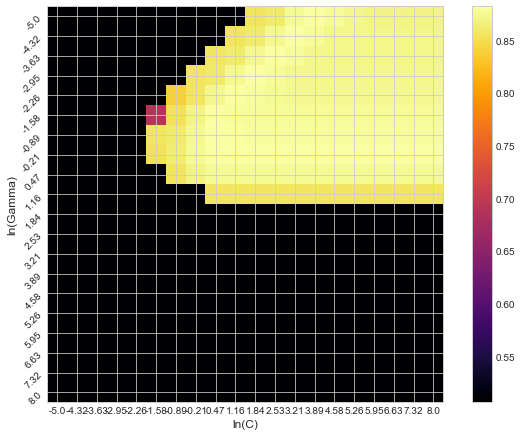

In [568]:
rbf_df = pd.DataFrame.from_dict(rbf_search.cv_results_)

C_rng = np.logspace(-5,8,20,base=math.e)
gamma_rng = np.logspace(-5,8,20,base=math.e)

rbf_scores = rbf_df.mean_test_score
rbf_scores = np.array(rbf_scores).reshape(len(gamma_rng),len(C_rng)).T

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.7)
plt.imshow(rbf_scores, interpolation='nearest', cmap=plt.get_cmap('inferno'))
plt.ylabel('ln(Gamma)')
plt.xlabel('ln(C)')
plt.colorbar()
plt.yticks(np.arange(len(gamma_rng)), np.round(np.log(gamma_rng),2), rotation=45)
plt.xticks(np.arange(len(C_rng)), np.round(np.log(C_rng), 2))
plt.show()

3.3.2. Evaluate results of RBF kernel SVM with the best hyperparameter values found

In [626]:
# plug in the best parameter found to test accuracy for test set

rbf_sc = SVMClassifier(kernel='rbf', C=1.6058997806999291, gamma=0.8101577349324269)
rbf_sc.fit(X_train, Y_train)
rbf_pred = rbf_sc.predict(X_test)
print(classification_report(Y_test, rbf_pred))

print(accuracy_score(Y_test, rbf_pred))

              precision    recall  f1-score   support

    negative       0.88      0.89      0.89       731
    positive       0.89      0.89      0.89       769

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500

0.888


In [616]:
rbf_wrong_idx = [w for w in range(len(rbf_pred)) if rbf_pred[w] != Y_test[w]]
rbf_correct_idx = [w for w in range(len(rbf_pred)) if rbf_pred[w] == Y_test[w]]

rbf_raw_wrong_samples = [test.review[i] for i in wrong_idx]
rbf_raw_correct_samples = [test.review[i] for i in correct_idx]

# 1. Length tokens
rbf_fn_mean_len = get_mean_len(X_test, Y_test, rbf_wrong_idx, 'positive')
rbf_fp_mean_len = get_mean_len(X_test, Y_test, rbf_wrong_idx, 'negative')
rbf_tn_mean_len = get_mean_len(X_test, Y_test, rbf_correct_idx, 'negative')
rbf_tp_mean_len = get_mean_len(X_test, Y_test, rbf_correct_idx, 'positive')
print('Finished calculating ave length')

# 2. Ave % punctuations
rbf_fn_mean_punc = get_mean_punc(test.review, Y_test, rbf_wrong_idx, 'positive')
rbf_fp_mean_punc = get_mean_punc(test.review, Y_test, rbf_wrong_idx, 'negative')
rbf_tn_mean_punc = get_mean_punc(test.review, Y_test, rbf_correct_idx, 'negative')
rbf_tp_mean_punc = get_mean_punc(test.review, Y_test, rbf_correct_idx, 'positive')
print('Finished calculating ave % punctuations')

# 3. Ave % negation words
rbf_fn_mean_neg = get_mean_dep(test.review, Y_test, rbf_wrong_idx, 'positive', 'neg')
rbf_fp_mean_neg = get_mean_dep(test.review, Y_test, rbf_wrong_idx, 'negative', 'neg')
rbf_tn_mean_neg = get_mean_dep(test.review, Y_test, rbf_correct_idx, 'negative', 'neg')
rbf_tp_mean_neg = get_mean_dep(test.review, Y_test, rbf_correct_idx, 'positive', 'neg')
print('Finished calculating ave % negation words')

# 4. Ave % adjectives
rbf_fn_mean_adj = get_mean_pos(test.review, Y_test, rbf_wrong_idx, 'positive', 'ADJ')
rbf_fp_mean_adj = get_mean_pos(test.review, Y_test, rbf_wrong_idx, 'negative', 'ADJ')
rbf_tn_mean_adj = get_mean_pos(test.review, Y_test, rbf_correct_idx, 'negative', 'ADJ')
rbf_tp_mean_adj = get_mean_pos(test.review, Y_test, rbf_correct_idx, 'positive', 'ADJ')
print('Finished calculating ave % adjectives')

# 5. Ave % words trimmed
rbf_fn_mean_trim = get_mean_trim(test.review, X_test, Y_test, rbf_wrong_idx, 'positive')
rbf_fp_mean_trim = get_mean_trim(test.review, X_test, Y_test, rbf_wrong_idx, 'negative')
rbf_tn_mean_trim = get_mean_trim(test.review, X_test, Y_test, rbf_correct_idx, 'negative')
rbf_tp_mean_trim = get_mean_trim(test.review, X_test, Y_test, rbf_correct_idx, 'positive')
print('Finished calculating ave % words')

# Structure: FP, TP, FN, TN
labels = ['False Positive', 'True Positive', 'False Negative', 'True Negative']
rbf_analysis = {'Punctuations': [rbf_fp_mean_punc, rbf_tp_mean_punc, rbf_fn_mean_punc, rbf_tn_mean_punc],
                'Adjectives': [rbf_fp_mean_adj, rbf_tp_mean_adj, rbf_fn_mean_adj, rbf_tn_mean_adj],
                'Negation Words': [rbf_fp_mean_neg, rbf_tp_mean_neg, rbf_fn_mean_neg, rbf_tn_mean_neg],
                'Tokens': [rbf_fp_mean_len, rbf_tp_mean_len, rbf_fn_mean_len, rbf_tn_mean_len],
                'Words Trimmed':  [rbf_fp_mean_trim, rbf_tp_mean_trim, rbf_fn_mean_trim, rbf_tn_mean_trim]
}

rbf_analysis_df = pd.DataFrame(rbf_analysis, index=labels)
rbf_analysis_df.style.background_gradient(axis=0)

Finished calculating ave length
Finished calculating ave % punctuations
Finished calculating ave % negation words
Finished calculating ave % adjectives
Finished calculating ave % words


,Punctuations,Adjectives,Negation Words,Tokens,Words Trimmed
False Positive,0.792525,18.280000,0.940000,102.020000,53.830000
True Positive,0.705701,21.630000,0.870000,117.060000,53.140000
False Negative,0.801216,17.910000,1.210000,101.520000,53.940000
True Negative,0.722078,20.270000,1.220000,113.830000,53.360000


### 3.4 SVM with polynomial kernel

3.4.1. Hyperparameter tuning (C, degree)

In [529]:
# self testing code - remove before submission
# Polynomial kernel

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

C_rng = np.logspace(-5,8,20, base=math.e)
d_range = np.linspace(1, 4, 4)

# Hyperparameter tuning
params_grid = {'kernel':['poly'],
               'C': C_rng,
               'degree': d_range}

poly_svc = svm.SVC()
poly_sc = SVMClassifier(kernel='poly')
poly_search = GridSearchCV(poly_svc, params_grid, cv=5, verbose=10)
poly_X_train = poly_sc.vectorizer.fit_transform(X_train)
poly_search.fit(poly_X_train, Y_train)
print(poly_search.best_params_)
print(poly_search.best_estimator_)
print(poly_search.best_score_)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5; 1/80] START C=0.006737946999085469, degree=1.0, kernel=poly............
[CV 1/5; 1/80] END C=0.006737946999085469, degree=1.0, kernel=poly;, score=0.506 total time=  14.9s
[CV 2/5; 1/80] START C=0.006737946999085469, degree=1.0, kernel=poly............
[CV 2/5; 1/80] END C=0.006737946999085469, degree=1.0, kernel=poly;, score=0.506 total time=  16.5s
[CV 3/5; 1/80] START C=0.006737946999085469, degree=1.0, kernel=poly............
[CV 3/5; 1/80] END C=0.006737946999085469, degree=1.0, kernel=poly;, score=0.506 total time=  16.2s
[CV 4/5; 1/80] START C=0.006737946999085469, degree=1.0, kernel=poly............
[CV 4/5; 1/80] END C=0.006737946999085469, degree=1.0, kernel=poly;, score=0.507 total time=  16.4s
[CV 5/5; 1/80] START C=0.006737946999085469, degree=1.0, kernel=poly............
[CV 5/5; 1/80] END C=0.006737946999085469, degree=1.0, kernel=poly;, score=0.507 total time=  16.3s
[CV 1/5; 2/80] START C=0.00673794

[CV 1/5; 10/80] END C=0.026474349785326985, degree=2.0, kernel=poly;, score=0.506 total time=  16.8s
[CV 2/5; 10/80] START C=0.026474349785326985, degree=2.0, kernel=poly...........
[CV 2/5; 10/80] END C=0.026474349785326985, degree=2.0, kernel=poly;, score=0.506 total time=  16.7s
[CV 3/5; 10/80] START C=0.026474349785326985, degree=2.0, kernel=poly...........
[CV 3/5; 10/80] END C=0.026474349785326985, degree=2.0, kernel=poly;, score=0.506 total time=  16.6s
[CV 4/5; 10/80] START C=0.026474349785326985, degree=2.0, kernel=poly...........
[CV 4/5; 10/80] END C=0.026474349785326985, degree=2.0, kernel=poly;, score=0.507 total time=  16.7s
[CV 5/5; 10/80] START C=0.026474349785326985, degree=2.0, kernel=poly...........
[CV 5/5; 10/80] END C=0.026474349785326985, degree=2.0, kernel=poly;, score=0.507 total time=  16.6s
[CV 1/5; 11/80] START C=0.026474349785326985, degree=3.0, kernel=poly...........
[CV 1/5; 11/80] END C=0.026474349785326985, degree=3.0, kernel=poly;, score=0.506 total ti

[CV 2/5; 19/80] END C=0.10402147666803764, degree=3.0, kernel=poly;, score=0.506 total time=  16.6s
[CV 3/5; 19/80] START C=0.10402147666803764, degree=3.0, kernel=poly............
[CV 3/5; 19/80] END C=0.10402147666803764, degree=3.0, kernel=poly;, score=0.506 total time=  16.6s
[CV 4/5; 19/80] START C=0.10402147666803764, degree=3.0, kernel=poly............
[CV 4/5; 19/80] END C=0.10402147666803764, degree=3.0, kernel=poly;, score=0.507 total time=  16.8s
[CV 5/5; 19/80] START C=0.10402147666803764, degree=3.0, kernel=poly............
[CV 5/5; 19/80] END C=0.10402147666803764, degree=3.0, kernel=poly;, score=0.507 total time=  16.5s
[CV 1/5; 20/80] START C=0.10402147666803764, degree=4.0, kernel=poly............
[CV 1/5; 20/80] END C=0.10402147666803764, degree=4.0, kernel=poly;, score=0.506 total time=  16.6s
[CV 2/5; 20/80] START C=0.10402147666803764, degree=4.0, kernel=poly............
[CV 2/5; 20/80] END C=0.10402147666803764, degree=4.0, kernel=poly;, score=0.506 total time=  1

[CV 3/5; 28/80] END C=0.40871514110598417, degree=4.0, kernel=poly;, score=0.506 total time=  16.6s
[CV 4/5; 28/80] START C=0.40871514110598417, degree=4.0, kernel=poly............
[CV 4/5; 28/80] END C=0.40871514110598417, degree=4.0, kernel=poly;, score=0.507 total time=  16.8s
[CV 5/5; 28/80] START C=0.40871514110598417, degree=4.0, kernel=poly............
[CV 5/5; 28/80] END C=0.40871514110598417, degree=4.0, kernel=poly;, score=0.507 total time=  16.7s
[CV 1/5; 29/80] START C=0.8101577349324269, degree=1.0, kernel=poly.............
[CV 1/5; 29/80] END C=0.8101577349324269, degree=1.0, kernel=poly;, score=0.877 total time=  11.9s
[CV 2/5; 29/80] START C=0.8101577349324269, degree=1.0, kernel=poly.............
[CV 2/5; 29/80] END C=0.8101577349324269, degree=1.0, kernel=poly;, score=0.879 total time=  12.0s
[CV 3/5; 29/80] START C=0.8101577349324269, degree=1.0, kernel=poly.............
[CV 3/5; 29/80] END C=0.8101577349324269, degree=1.0, kernel=poly;, score=0.872 total time=  11.8

[CV 4/5; 37/80] END C=3.1832246912598827, degree=1.0, kernel=poly;, score=0.874 total time=  12.4s
[CV 5/5; 37/80] START C=3.1832246912598827, degree=1.0, kernel=poly.............
[CV 5/5; 37/80] END C=3.1832246912598827, degree=1.0, kernel=poly;, score=0.873 total time=  12.5s
[CV 1/5; 38/80] START C=3.1832246912598827, degree=2.0, kernel=poly.............
[CV 1/5; 38/80] END C=3.1832246912598827, degree=2.0, kernel=poly;, score=0.867 total time=  15.1s
[CV 2/5; 38/80] START C=3.1832246912598827, degree=2.0, kernel=poly.............
[CV 2/5; 38/80] END C=3.1832246912598827, degree=2.0, kernel=poly;, score=0.870 total time=  16.8s
[CV 3/5; 38/80] START C=3.1832246912598827, degree=2.0, kernel=poly.............
[CV 3/5; 38/80] END C=3.1832246912598827, degree=2.0, kernel=poly;, score=0.853 total time=  16.8s
[CV 4/5; 38/80] START C=3.1832246912598827, degree=2.0, kernel=poly.............
[CV 4/5; 38/80] END C=3.1832246912598827, degree=2.0, kernel=poly;, score=0.874 total time=  16.7s
[

[CV 5/5; 46/80] END C=12.507341469611143, degree=2.0, kernel=poly;, score=0.882 total time=  16.5s
[CV 1/5; 47/80] START C=12.507341469611143, degree=3.0, kernel=poly.............
[CV 1/5; 47/80] END C=12.507341469611143, degree=3.0, kernel=poly;, score=0.759 total time=  16.7s
[CV 2/5; 47/80] START C=12.507341469611143, degree=3.0, kernel=poly.............
[CV 2/5; 47/80] END C=12.507341469611143, degree=3.0, kernel=poly;, score=0.755 total time=  16.6s
[CV 3/5; 47/80] START C=12.507341469611143, degree=3.0, kernel=poly.............
[CV 3/5; 47/80] END C=12.507341469611143, degree=3.0, kernel=poly;, score=0.759 total time=  16.6s
[CV 4/5; 47/80] START C=12.507341469611143, degree=3.0, kernel=poly.............
[CV 4/5; 47/80] END C=12.507341469611143, degree=3.0, kernel=poly;, score=0.761 total time=  17.0s
[CV 5/5; 47/80] START C=12.507341469611143, degree=3.0, kernel=poly.............
[CV 5/5; 47/80] END C=12.507341469611143, degree=3.0, kernel=poly;, score=0.751 total time=  16.7s
[

[CV 1/5; 56/80] END C=49.143119261097524, degree=4.0, kernel=poly;, score=0.512 total time=  16.7s
[CV 2/5; 56/80] START C=49.143119261097524, degree=4.0, kernel=poly.............
[CV 2/5; 56/80] END C=49.143119261097524, degree=4.0, kernel=poly;, score=0.516 total time=  16.9s
[CV 3/5; 56/80] START C=49.143119261097524, degree=4.0, kernel=poly.............
[CV 3/5; 56/80] END C=49.143119261097524, degree=4.0, kernel=poly;, score=0.513 total time=  16.6s
[CV 4/5; 56/80] START C=49.143119261097524, degree=4.0, kernel=poly.............
[CV 4/5; 56/80] END C=49.143119261097524, degree=4.0, kernel=poly;, score=0.515 total time=  16.8s
[CV 5/5; 56/80] START C=49.143119261097524, degree=4.0, kernel=poly.............
[CV 5/5; 56/80] END C=49.143119261097524, degree=4.0, kernel=poly;, score=0.513 total time=  16.6s
[CV 1/5; 57/80] START C=97.41180148195387, degree=1.0, kernel=poly..............
[CV 1/5; 57/80] END C=97.41180148195387, degree=1.0, kernel=poly;, score=0.868 total time=  13.7s
[C

[CV 2/5; 65/80] END C=382.7447894740212, degree=1.0, kernel=poly;, score=0.876 total time=  13.4s
[CV 3/5; 65/80] START C=382.7447894740212, degree=1.0, kernel=poly..............
[CV 3/5; 65/80] END C=382.7447894740212, degree=1.0, kernel=poly;, score=0.861 total time=  12.3s
[CV 4/5; 65/80] START C=382.7447894740212, degree=1.0, kernel=poly..............
[CV 4/5; 65/80] END C=382.7447894740212, degree=1.0, kernel=poly;, score=0.874 total time=  12.6s
[CV 5/5; 65/80] START C=382.7447894740212, degree=1.0, kernel=poly..............
[CV 5/5; 65/80] END C=382.7447894740212, degree=1.0, kernel=poly;, score=0.873 total time=  13.6s
[CV 1/5; 66/80] START C=382.7447894740212, degree=2.0, kernel=poly..............
[CV 1/5; 66/80] END C=382.7447894740212, degree=2.0, kernel=poly;, score=0.867 total time=  14.9s
[CV 2/5; 66/80] START C=382.7447894740212, degree=2.0, kernel=poly..............
[CV 2/5; 66/80] END C=382.7447894740212, degree=2.0, kernel=poly;, score=0.870 total time=  16.9s
[CV 3/5

[CV 3/5; 74/80] END C=1503.8585842871576, degree=2.0, kernel=poly;, score=0.853 total time=  16.8s
[CV 4/5; 74/80] START C=1503.8585842871576, degree=2.0, kernel=poly.............
[CV 4/5; 74/80] END C=1503.8585842871576, degree=2.0, kernel=poly;, score=0.874 total time=  17.3s
[CV 5/5; 74/80] START C=1503.8585842871576, degree=2.0, kernel=poly.............
[CV 5/5; 74/80] END C=1503.8585842871576, degree=2.0, kernel=poly;, score=0.882 total time=  16.8s
[CV 1/5; 75/80] START C=1503.8585842871576, degree=3.0, kernel=poly.............
[CV 1/5; 75/80] END C=1503.8585842871576, degree=3.0, kernel=poly;, score=0.759 total time=  16.8s
[CV 2/5; 75/80] START C=1503.8585842871576, degree=3.0, kernel=poly.............
[CV 2/5; 75/80] END C=1503.8585842871576, degree=3.0, kernel=poly;, score=0.755 total time=  16.7s
[CV 3/5; 75/80] START C=1503.8585842871576, degree=3.0, kernel=poly.............
[CV 3/5; 75/80] END C=1503.8585842871576, degree=3.0, kernel=poly;, score=0.759 total time=  16.7s
[

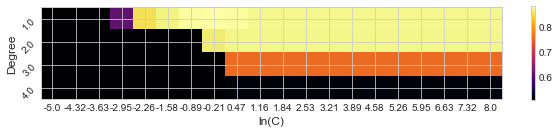

In [570]:
poly_df = pd.DataFrame.from_dict(poly_search.cv_results_)

C_rng = np.logspace(-5,8,20,base=math.e)
d_range = np.linspace(1, 4, 4)

poly_scores = poly_df.mean_test_score
poly_scores = np.array(poly_scores).reshape(len(C_rng), len(d_range)).T

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.8)
plt.imshow(poly_scores, interpolation='nearest', cmap=plt.get_cmap('inferno'))
plt.ylabel('Degree')
plt.xlabel('ln(C)')
plt.colorbar(shrink=0.2)
plt.yticks(np.arange(len(d_range)),d_range, rotation=45)
plt.xticks(np.arange(len(C_rng)), np.round(np.log(C_rng), 2))
plt.show()

3.4.2. Evaluate results of polynomial kernel SVM with the best hyperparameter values found

In [548]:
# plug in the best parameter found to test accuracy for test set

poly_sc = SVMClassifier(kernel='poly', C=0.8101577349324269, d=1)
poly_sc.fit(X_train, Y_train)
poly_pred = poly_sc.predict(X_test)
print(classification_report(Y_test, poly_pred))
print(accuracy_score(Y_test, poly_pred))

              precision    recall  f1-score   support

    negative       0.87      0.88      0.88       731
    positive       0.89      0.87      0.88       769

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



In [617]:
poly_wrong_idx = [w for w in range(len(poly_pred)) if poly_pred[w] != Y_test[w]]
poly_correct_idx = [w for w in range(len(poly_pred)) if poly_pred[w] == Y_test[w]]

poly_raw_wrong_samples = [test.review[i] for i in wrong_idx]
poly_raw_correct_samples = [test.review[i] for i in correct_idx]

# 1. Ave number of tokens
poly_fn_mean_len = get_mean_len(X_test, Y_test, poly_wrong_idx, 'positive')
poly_fp_mean_len = get_mean_len(X_test, Y_test, poly_wrong_idx, 'negative')
poly_tn_mean_len = get_mean_len(X_test, Y_test, poly_correct_idx, 'negative')
poly_tp_mean_len = get_mean_len(X_test, Y_test, poly_correct_idx, 'positive')
print('Finished calculating ave length')

# 2. Ave % punctuations
poly_fn_mean_punc = get_mean_punc(test.review, Y_test, poly_wrong_idx, 'positive')
poly_fp_mean_punc = get_mean_punc(test.review, Y_test, poly_wrong_idx, 'negative')
poly_tn_mean_punc = get_mean_punc(test.review, Y_test, poly_correct_idx, 'negative')
poly_tp_mean_punc = get_mean_punc(test.review, Y_test, poly_correct_idx, 'positive')
print('Finished calculating ave % punctuations')

# 3. Ave % negation words
poly_fn_mean_neg = get_mean_dep(test.review, Y_test, poly_wrong_idx, 'positive', 'neg')
poly_fp_mean_neg = get_mean_dep(test.review, Y_test, poly_wrong_idx, 'negative', 'neg')
poly_tn_mean_neg = get_mean_dep(test.review, Y_test, poly_correct_idx, 'negative', 'neg')
poly_tp_mean_neg = get_mean_dep(test.review, Y_test, poly_correct_idx, 'positive', 'neg')
print('Finished calculating ave % negation words')

# 4. Ave % adjectives
poly_fn_mean_adj = get_mean_pos(test.review, Y_test, poly_wrong_idx, 'positive', 'ADJ')
poly_fp_mean_adj = get_mean_pos(test.review, Y_test, poly_wrong_idx, 'negative', 'ADJ')
poly_tn_mean_adj = get_mean_pos(test.review, Y_test, poly_correct_idx, 'negative', 'ADJ')
poly_tp_mean_adj = get_mean_pos(test.review, Y_test, poly_correct_idx, 'positive', 'ADJ')
print('Finished calculating ave % adjectives')

# 5. Ave % words trimmed
poly_fn_mean_trim = get_mean_trim(test.review, X_test, Y_test, poly_wrong_idx, 'positive')
poly_fp_mean_trim = get_mean_trim(test.review, X_test, Y_test, poly_wrong_idx, 'negative')
poly_tn_mean_trim = get_mean_trim(test.review, X_test, Y_test, poly_correct_idx, 'negative')
poly_tp_mean_trim = get_mean_trim(test.review, X_test, Y_test, poly_correct_idx, 'positive')
print('Finished calculating ave % words trimmed')


# Structure: FP, TP, FN, TN
labels = ['False Positive', 'True Positive', 'False Negative', 'True Negative']
poly_analysis = {'Punctuations': [poly_fp_mean_punc, poly_tp_mean_punc, poly_fn_mean_punc, poly_tn_mean_punc],
                 'Adjectives': [poly_fp_mean_adj, poly_tp_mean_adj, poly_fn_mean_adj, poly_tn_mean_adj],
                 'Negation Words': [poly_fp_mean_neg, poly_tp_mean_neg, poly_fn_mean_neg, poly_tn_mean_neg],
                 'Tokens': [poly_fp_mean_len, poly_tp_mean_len, poly_fn_mean_len, poly_tn_mean_len],
                 'Words Trimmed':  [poly_fp_mean_trim, poly_tp_mean_trim, poly_fn_mean_trim, poly_tn_mean_trim]
}

poly_analysis_df = pd.DataFrame(poly_analysis, index=labels)

poly_analysis_df.style.background_gradient(axis=0)

Finished calculating ave length
Finished calculating ave % punctuations
Finished calculating ave % negation words
Finished calculating ave % adjectives
Finished calculating ave % words trimmed


,Punctuations,Adjectives,Negation Words,Tokens,Words Trimmed
False Positive,0.790918,18.530000,1.000000,102.690000,53.670000
True Positive,0.706090,21.630000,0.870000,117.110000,53.090000
False Negative,0.786827,18.300000,1.130000,102.740000,54.170000
True Negative,0.721856,20.250000,1.220000,113.820000,53.380000


### 4. Summarising results of all kernels

4.1 Average percentage of punctuations in reviews (by classification result)

<Figure size 432x288 with 0 Axes>

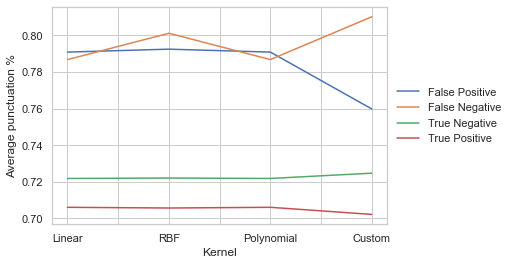

In [672]:
kernels = ['Linear', 'RBF', 'Polynomial', 'Custom']

characteristics = 'Punctuations'

punctuations = {'False Positive': [analysis_df[characteristics]['False Positive'],
                                  rbf_analysis_df[characteristics]['False Positive'],
                                  poly_analysis_df[characteristics]['False Positive'],
                                  cus_analysis_df[characteristics]['False Positive']],
                'False Negative': [analysis_df[characteristics]['False Negative'],
                                  rbf_analysis_df[characteristics]['False Negative'],
                                  poly_analysis_df[characteristics]['False Negative'],
                                  cus_analysis_df[characteristics]['False Negative']],
                'True Negative': [analysis_df[characteristics]['True Negative'],
                                  rbf_analysis_df[characteristics]['True Negative'],
                                  poly_analysis_df[characteristics]['True Negative'],
                                  cus_analysis_df[characteristics]['True Negative']],
                'True Positive': [analysis_df[characteristics]['True Positive'],
                                  rbf_analysis_df[characteristics]['True Positive'],
                                  poly_analysis_df[characteristics]['True Positive'],
                                  cus_analysis_df[characteristics]['True Positive']],
                
    
}

punctuations_df = pd.DataFrame(punctuations, index = kernels)
punc_plot = plt.figure()
punctuations_df.plot(xlabel='Kernel', 
                     ylabel='Average punctuation %')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

4.2 Average percentage of adjectives in reviews (by classification result)

<Figure size 432x288 with 0 Axes>

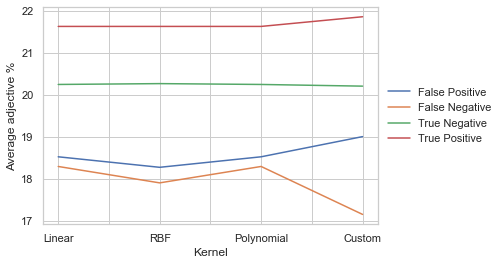

In [671]:
kernels = ['Linear', 'RBF', 'Polynomial', 'Custom']

characteristics = 'Adjectives'

adj = {'False Positive': [analysis_df[characteristics]['False Positive'],
                          rbf_analysis_df[characteristics]['False Positive'],
                          poly_analysis_df[characteristics]['False Positive'],
                          cus_analysis_df[characteristics]['False Positive']],
        'False Negative': [analysis_df[characteristics]['False Negative'],
                          rbf_analysis_df[characteristics]['False Negative'],
                          poly_analysis_df[characteristics]['False Negative'],
                          cus_analysis_df[characteristics]['False Negative']],
        'True Negative': [analysis_df[characteristics]['True Negative'],
                          rbf_analysis_df[characteristics]['True Negative'],
                          poly_analysis_df[characteristics]['True Negative'],
                          cus_analysis_df[characteristics]['True Negative']],
        'True Positive': [analysis_df[characteristics]['True Positive'],
                          rbf_analysis_df[characteristics]['True Positive'],
                          poly_analysis_df[characteristics]['True Positive'],
                          cus_analysis_df[characteristics]['True Positive']],

    
}

adj_df = pd.DataFrame(adj, index = kernels)
adj_plt = plt.figure()
adj_df.plot(xlabel='Kernel', 
            ylabel='Average adjective %')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

4.3 Average percentage of negation words in reviews (by classification result)

<Figure size 432x288 with 0 Axes>

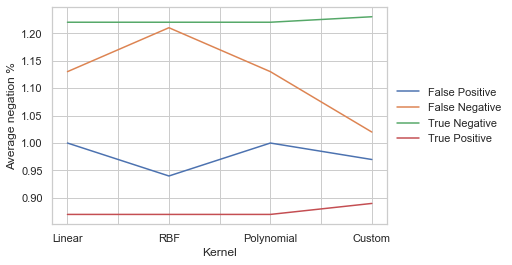

In [675]:
kernels = ['Linear', 'RBF', 'Polynomial', 'Custom']

characteristics = 'Negation Words'

neg = {'False Positive': [analysis_df[characteristics]['False Positive'],
                          rbf_analysis_df[characteristics]['False Positive'],
                          poly_analysis_df[characteristics]['False Positive'],
                          cus_analysis_df[characteristics]['False Positive']],
        'False Negative': [analysis_df[characteristics]['False Negative'],
                          rbf_analysis_df[characteristics]['False Negative'],
                          poly_analysis_df[characteristics]['False Negative'],
                          cus_analysis_df[characteristics]['False Negative']],
        'True Negative': [analysis_df[characteristics]['True Negative'],
                          rbf_analysis_df[characteristics]['True Negative'],
                          poly_analysis_df[characteristics]['True Negative'],
                          cus_analysis_df[characteristics]['True Negative']],
        'True Positive': [analysis_df[characteristics]['True Positive'],
                          rbf_analysis_df[characteristics]['True Positive'],
                          poly_analysis_df[characteristics]['True Positive'],
                          cus_analysis_df[characteristics]['True Positive']],

    
}

neg_df = pd.DataFrame(neg, index = kernels)
neg_plt = plt.figure()
neg_df.plot(xlabel='Kernel', 
            ylabel='Average negation %')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

4.4 Average length of review (by classification result)

<Figure size 432x288 with 0 Axes>

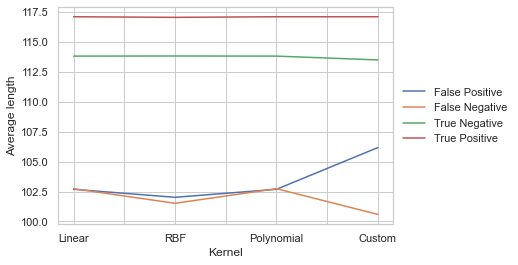

In [676]:
kernels = ['Linear', 'RBF', 'Polynomial', 'Custom']

characteristics = 'Tokens'

length = {'False Positive': [analysis_df[characteristics]['False Positive'],
                          rbf_analysis_df[characteristics]['False Positive'],
                          poly_analysis_df[characteristics]['False Positive'],
                          cus_analysis_df[characteristics]['False Positive']],
        'False Negative': [analysis_df[characteristics]['False Negative'],
                          rbf_analysis_df[characteristics]['False Negative'],
                          poly_analysis_df[characteristics]['False Negative'],
                          cus_analysis_df[characteristics]['False Negative']],
        'True Negative': [analysis_df[characteristics]['True Negative'],
                          rbf_analysis_df[characteristics]['True Negative'],
                          poly_analysis_df[characteristics]['True Negative'],
                          cus_analysis_df[characteristics]['True Negative']],
        'True Positive': [analysis_df[characteristics]['True Positive'],
                          rbf_analysis_df[characteristics]['True Positive'],
                          poly_analysis_df[characteristics]['True Positive'],
                          cus_analysis_df[characteristics]['True Positive']],

    
}

length_df = pd.DataFrame(length, index = kernels)
length_plt = plt.figure()
length_df.plot(xlabel='Kernel', 
            ylabel='Average length')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

4.5 Average percentage of words trimmed during data preprocessing (by classification result)

<Figure size 432x288 with 0 Axes>

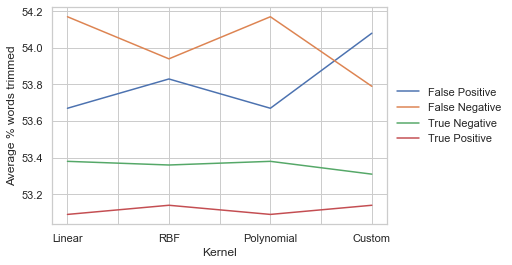

In [677]:
kernels = ['Linear', 'RBF', 'Polynomial', 'Custom']

characteristics = 'Words Trimmed'

trim = {'False Positive': [analysis_df[characteristics]['False Positive'],
                             rbf_analysis_df[characteristics]['False Positive'],
                             poly_analysis_df[characteristics]['False Positive'],
                             cus_analysis_df[characteristics]['False Positive']],
         'False Negative': [analysis_df[characteristics]['False Negative'],
                          rbf_analysis_df[characteristics]['False Negative'],
                          poly_analysis_df[characteristics]['False Negative'],
                          cus_analysis_df[characteristics]['False Negative']],
         'True Negative': [analysis_df[characteristics]['True Negative'],
                          rbf_analysis_df[characteristics]['True Negative'],
                          poly_analysis_df[characteristics]['True Negative'],
                          cus_analysis_df[characteristics]['True Negative']],
         'True Positive': [analysis_df[characteristics]['True Positive'],
                           rbf_analysis_df[characteristics]['True Positive'],
                          poly_analysis_df[characteristics]['True Positive'],
                          cus_analysis_df[characteristics]['True Positive']],

    
}

trim_df = pd.DataFrame(trim, index = kernels)
trim_plt = plt.figure()
trim_df.plot(xlabel='Kernel', 
            ylabel='Average % words trimmed')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))